# CIFAR-10

## 一、构造

In [9]:
import warnings
warnings.filterwarnings('ignore')

## 二、验证

In [1]:
!tree ../data/cifar-10/gen/

../data/cifar-10/gen/
├── nr_0.2_nt_asymmetric
│   ├── D_0_labels.npy
│   ├── D_0.npy
│   ├── D_a_labels.npy
│   ├── D_a.npy
│   ├── D_inc_0_data.npy
│   ├── D_inc_0_labels.npy
│   ├── D_tr_data_version_1.npy
│   ├── D_tr_data_version_2.npy
│   ├── D_tr_data_version_3.npy
│   ├── D_tr_labels_version_1.npy
│   ├── D_tr_labels_version_2.npy
│   ├── D_tr_labels_version_3.npy
│   ├── test_data.npy
│   └── test_labels.npy
└── nr_0.2_nt_symmetric
    ├── D_0_labels.npy
    ├── D_0.npy
    ├── D_a_labels.npy
    ├── D_a.npy
    ├── D_inc_0_data.npy
    ├── D_inc_0_labels.npy
    ├── D_tr_data_version_1.npy
    ├── D_tr_data_version_2.npy
    ├── D_tr_data_version_3.npy
    ├── D_tr_labels_version_1.npy
    ├── D_tr_labels_version_2.npy
    ├── D_tr_labels_version_3.npy
    ├── test_data.npy
    └── test_labels.npy

2 directories, 28 files


In [2]:
!tree ../ckpt/cifar-10/

../ckpt/cifar-10/
├── nr_0.2_nt_asymmetric
│   ├── model_p0.pth
│   ├── model_p1.pth
│   └── model_p2.pth
└── nr_0.2_nt_symmetric
    ├── model_p0.pth
    ├── model_p1.pth
    ├── model_p2.pth
    └── model_p3.pth

2 directories, 7 files


### 1、验证遗忘

#### 条形图

验证 base_dir_2 数据集:


/tmp/ipykernel_68029/2340010099.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)
/tmp/ipykernel_68029/2340010099.py:15: FutureWarning: You a

版本 1:
数据形状: torch.Size([14986, 3, 32, 32]), 标签形状: torch.Size([14986])
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
版本 2:
数据形状: torch.Size([12514, 3, 32, 32]), 标签形状: torch.Size([12514])
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
版本 3:
数据形状: torch.Size([10043, 3, 32, 32]), 标签形状: torch.Size([10043])
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 5

IndexError: index 10 is out of bounds for axis 0 with size 10

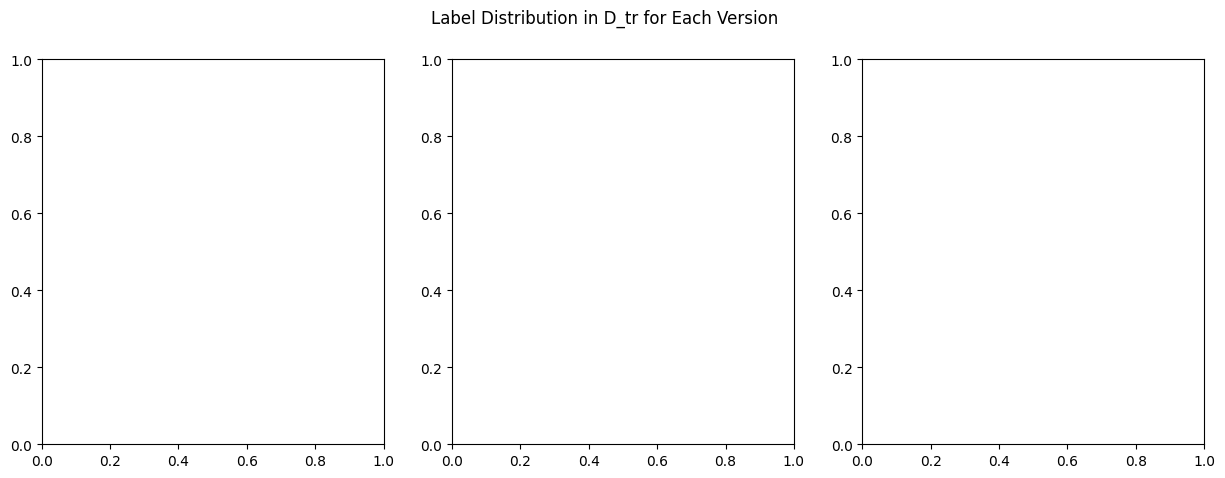

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

num_versions = 3  # 假设有3个版本的增量数据集
num_classes = 10  # CIFAR-10 共有10个类

# 函数用于加载每个版本的 D_tr 数据集
def load_d_tr(version, base_dir):
    data_path = os.path.join(base_dir, f"D_tr_data_version_{version}.npy")
    labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")
    
    data = torch.load(data_path)
    labels = torch.load(labels_path)
    
    # 验证数据形状和标签范围
    print(f"版本 {version}:")
    print(f"数据形状: {data.shape}, 标签形状: {labels.shape}")
    print(f"标签唯一值: {np.unique(labels)}")
    
    return data, labels

# 验证每个版本 D_tr 的标签分布变化并统一纵坐标
def plot_label_distribution(base_dir):
    plt.style.use("default")
    fig, axs = plt.subplots(1, num_versions, figsize=(15, 5))
    fig.suptitle("Label Distribution in D_tr for Each Version")

    max_count = 0  # 初始化最大频率值

    # 计算所有版本中的最大频率值
    for version in range(1, num_versions + 1):
        _, labels = load_d_tr(version, base_dir)
        _, counts = np.unique(labels, return_counts=True)
        max_count = max(max_count, max(counts))

    # 绘图并设置统一的纵坐标
    for version in range(1, num_versions + 1):
        _, labels = load_d_tr(version, base_dir)
        unique, counts = np.unique(labels, return_counts=True)
        
        # 为了保持 x 轴一致，确保横坐标是从 0 到 9（共10个类）
        full_counts = np.zeros(num_classes)
        full_counts[unique] = counts  # 填充实际的计数值
        
        axs[version - 1].bar(range(num_classes), full_counts, color='skyblue')
        axs[version - 1].set_title(f"Version {version}")
        axs[version - 1].set_xlabel("Label")
        axs[version - 1].set_ylabel("Frequency")
        axs[version - 1].set_xticks(range(num_classes))  # 保证横轴一致
        axs[version - 1].set_ylim(0, max_count)  # 设置统一的纵坐标最大值

    plt.tight_layout()
    fig.subplots_adjust(top=0.88)  # 调整顶部以避免标题与图形重叠
    plt.show()

# 定义数据集的路径
# base_dir_1 = "../data/cifar-10/gen/nr_0.2_nt_asymmetric"
# 加载每个版本的 D_tr 并验证其分布
# print("验证 base_dir_1 数据集:")
# plot_label_distribution(base_dir_1)

# 定义数据集的路径
base_dir_2 = "../data/cifar-10/gen/nr_0.2_nt_symmetric"
print("验证 base_dir_2 数据集:")
plot_label_distribution(base_dir_2)


### 2、验证噪声

#### 统计量

In [32]:
import os
import numpy as np
import torch

# 定义数据集的路径
base_dir_asym = "../data/cifar-10/gen/nr_0.2_nt_asymmetric"
base_dir_sym = "../data/cifar-10/gen/nr_0.2_nt_symmetric"
num_versions = 3  # 假设有3个增量版本
num_replay_samples = 2500  # D_a 包含的样本数


# 加载每个版本的原始标签和噪声标签
def load_labels(version, base_dir):
    original_labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")
    noisy_labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")

    print(f"Loading Original Labels from: {original_labels_path}")
    print(f"Loading Noisy Labels from: {noisy_labels_path}")

    original_labels = torch.load(original_labels_path)
    noisy_labels = torch.load(noisy_labels_path)

    noisy_labels = noisy_labels[num_replay_samples:]  # 剔除重放数据 D_a 的标签部分

    print(f"Loaded Original Labels (first 10): {original_labels[:10]}")
    print(f"Loaded Noisy Labels (first 10): {noisy_labels[:10]}")

    return original_labels, noisy_labels


# 验证噪声效果的通用函数
def verify_noise(base_dir, is_symmetric=True):
    for version in range(1, num_versions + 1):
        original_labels, noisy_labels = load_labels(version, base_dir)

        print(f"original_labels.shape: {original_labels.shape}")
        print(f"noisy_labels.shape: {noisy_labels.shape}")

        print("Checking Noise...")
        print(f"Verifying Noise for Version {version}")
        noise_mask = original_labels != noisy_labels  # 计算噪声

        noise_count = np.sum(noise_mask)
        print(f"Version {version}: Noise count = {noise_count}")

        if noise_count > 0:
            noisy_samples = original_labels[noise_mask]
            noisy_labels_samples = noisy_labels[noise_mask]
            print(f"Original Labels (first 10 noisy samples): {noisy_samples[:10]}")
            print(f"Noisy Labels (first 10 noisy samples): {noisy_labels_samples[:10]}")

            if not is_symmetric:
                asymmetric_mapping = {
                    0: 2,
                    2: 0,
                    4: 6,
                    6: 4,
                    8: 0,
                }
                for orig_label, noisy_label in zip(noisy_samples, noisy_labels_samples):
                    expected_label = asymmetric_mapping.get(orig_label)
                    if expected_label is not None and noisy_label != expected_label:
                        print(
                            f"Error: Original {orig_label} -> Expected {expected_label}, but got {noisy_label}"
                        )


# 验证对称噪声和非对称噪声效果
print("对称噪声验证：")
verify_noise(base_dir_sym, is_symmetric=True)

print("非对称噪声验证：")
verify_noise(base_dir_asym, is_symmetric=False)

对称噪声验证：
Loading Original Labels from: ../data/cifar-10/gen/nr_0.2_nt_symmetric/D_tr_labels_version_1.npy
Loading Noisy Labels from: ../data/cifar-10/gen/nr_0.2_nt_symmetric/D_tr_labels_version_1.npy
Loaded Original Labels (first 10): tensor([9, 4, 6, 2, 4, 2, 9, 7, 8, 8])
Loaded Noisy Labels (first 10): tensor([5, 8, 8, 1, 7, 7, 0, 8, 4, 4])
original_labels.shape: torch.Size([21317])
noisy_labels.shape: torch.Size([18817])
Checking Noise...
Verifying Noise for Version 1


RuntimeError: The size of tensor a (21317) must match the size of tensor b (18817) at non-singleton dimension 0

#### 小提琴图

Version 1: original_labels size = 25000, noisy_labels size = 21317
Version 2: original_labels size = 25000, noisy_labels size = 18844
Version 3: original_labels size = 25000, noisy_labels size = 16371


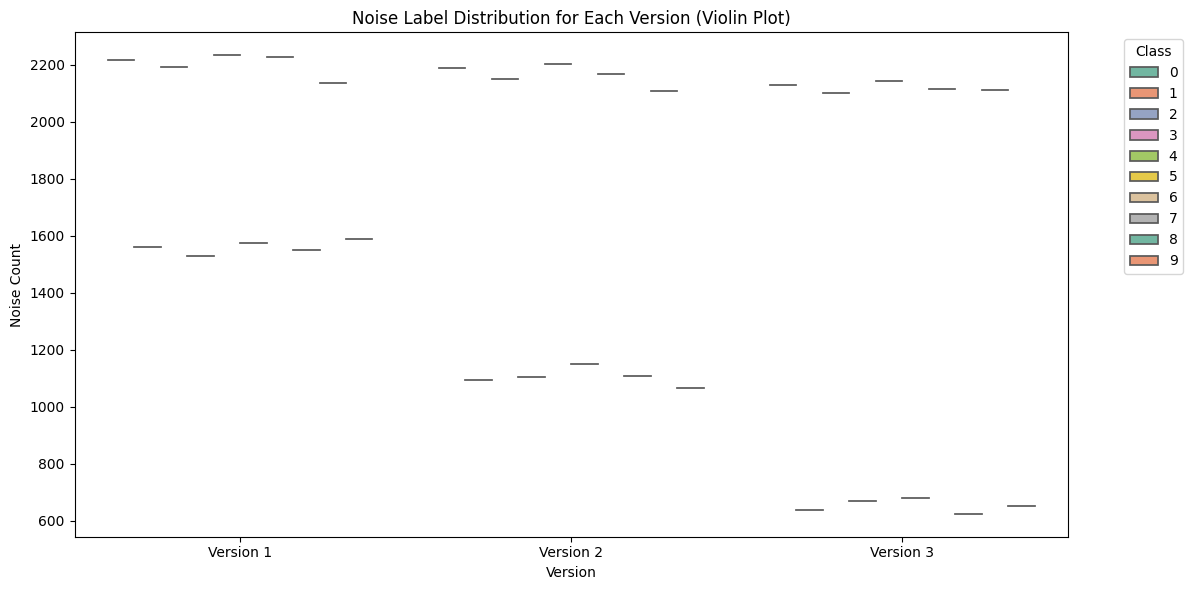

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch  # 添加torch库

num_versions = 3  # 假设有3个增量版本
num_classes = 10  # CIFAR-10 共有10个类
num_replay_samples = 2500  # D_a 包含的样本数

# 加载每个版本的原始标签和噪声标签
def load_labels(version, base_dir):
    original_labels_path = os.path.join(base_dir, "D_inc_0_labels.npy")  # 修正为初始增量标签路径
    noisy_labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")

    try:
        original_labels = torch.load(original_labels_path).numpy()
        noisy_labels = torch.load(noisy_labels_path).numpy()

        # 输出标签的形状以进行调试
        print(f"Version {version}: original_labels size = {original_labels.size}, noisy_labels size = {noisy_labels.size}")

        # 确保 noisy_labels 是一维数组
        if noisy_labels.ndim > 1:
            noisy_labels = noisy_labels.flatten()

        # 确保 noisy_labels 不会超过 original_labels 的长度
        if len(noisy_labels) > len(original_labels):
            noisy_labels = noisy_labels[:len(original_labels)]

        # 剔除重放数据 D_a 的标签部分
        noisy_labels = noisy_labels[num_replay_samples:]  # 从增量部分开始

        return original_labels, noisy_labels
    except Exception as e:
        print(f"Error loading labels for version {version}: {e}")
        return None, None

# 计算并可视化噪声标签比例的变化，使用小提琴图
def plot_noise_violin(base_dir):
    plt.style.use("default")
    plt.figure(figsize=(12, 6))  # 设置整体图像大小

    all_noise_data = []
    all_classes = []
    all_versions = []

    for version in range(1, num_versions + 1):
        original_labels, noisy_labels = load_labels(version, base_dir)
        if original_labels is None or noisy_labels is None:
            continue  # 跳过无法加载的版本

        # 统计噪声标签的数量
        noise_mask = (original_labels != noisy_labels)  # 标签不同的部分即为噪声
        noisy_labels_only = noisy_labels[noise_mask]

        # 对于每个类，计算噪声标签的数量并记录
        for label in range(num_classes):
            noise_per_class = np.sum(noisy_labels_only == label)

            # 记录所有噪声数据、对应的类以及版本
            all_noise_data.append(noise_per_class)  # 直接存储噪声标签数量
            all_classes.append(label)
            all_versions.append(f"Version {version}")

    # 使用Seaborn的小提琴图进行可视化
    sns.violinplot(x=all_versions, y=all_noise_data, hue=all_classes, split=True, inner="quart", palette="Set2")
    plt.title("Noise Label Distribution for Each Version (Violin Plot)")
    plt.xlabel("Version")
    plt.ylabel("Noise Count")
    plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')  # 添加图例
    plt.tight_layout()
    plt.show()

# 定义数据集的路径
base_dir = "../data/cifar-10/gen/nr_0.2_nt_symmetric"
# 验证并使用小提琴图可视化各版本中的标签噪声分布
plot_noise_violin(base_dir)


#### 条形图

Error loading labels for version 1: [Errno 2] No such file or directory: '../data/cifar-10/gen/nr_0.2_nt_asymmetric/D_inc_0_labels.npy'
Error loading labels for version 2: [Errno 2] No such file or directory: '../data/cifar-10/gen/nr_0.2_nt_asymmetric/D_inc_0_labels.npy'
Error loading labels for version 3: [Errno 2] No such file or directory: '../data/cifar-10/gen/nr_0.2_nt_asymmetric/D_inc_0_labels.npy'


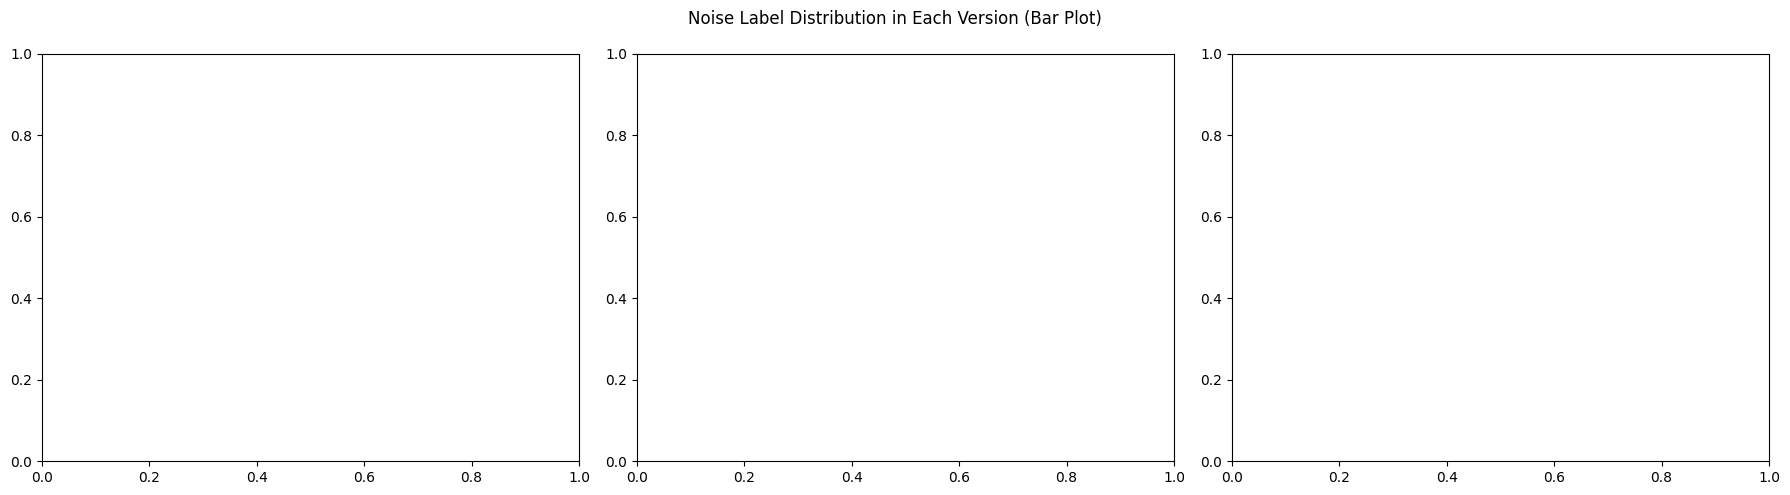

Version 1: original_labels size = 25000, noisy_labels size = 21317
Version 2: original_labels size = 25000, noisy_labels size = 18844
Version 3: original_labels size = 25000, noisy_labels size = 16371


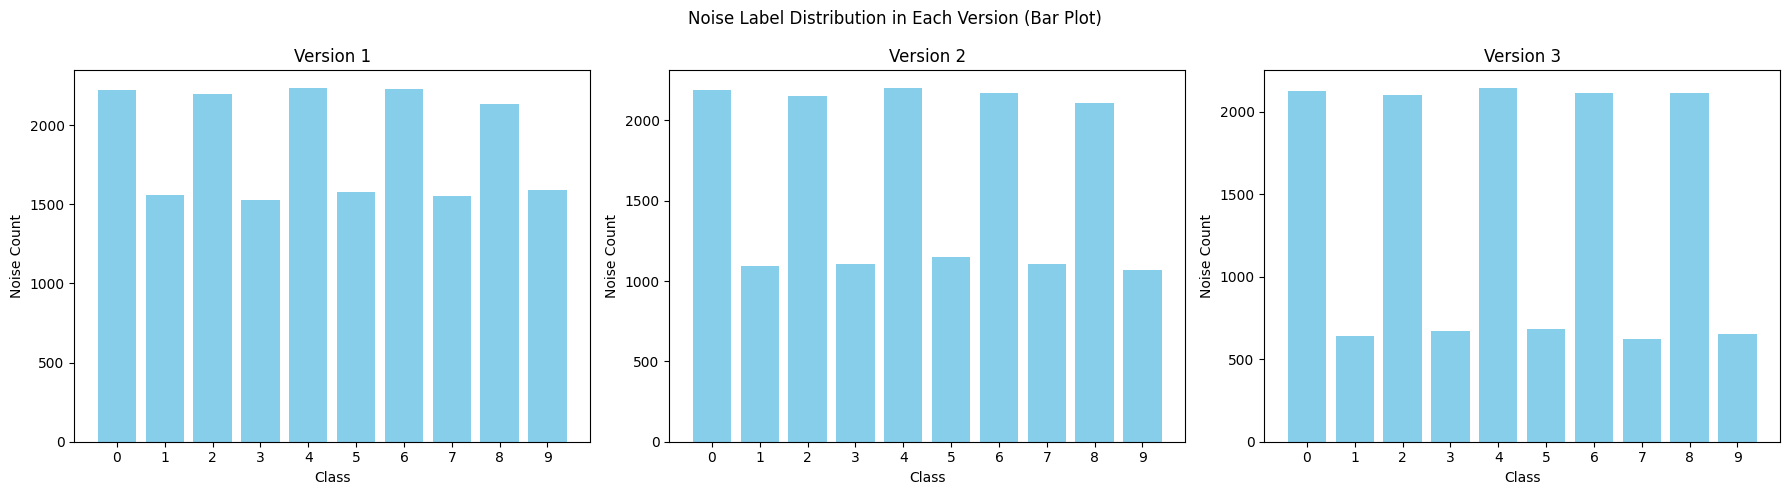

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# 定义数据集的路径
base_dir_asym = "../data/cifar-10/gen/nr_0.2_nt_asymmetric"
base_dir_sym = "../data/cifar-10/gen/nr_0.2_nt_symmetric"
num_versions = 3  # 假设有3个增量版本
num_classes = 10  # CIFAR-10 共有10个类
num_replay_samples = 2500  # D_a 包含的样本数


# 加载每个版本的原始标签和噪声标签
def load_labels(version, base_dir):
    original_labels_path = os.path.join(
        base_dir, f"D_inc_0_labels.npy"
    )  # 使用固定的增量标签文件
    noisy_labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")

    try:
        original_labels = torch.load(original_labels_path).numpy()  # 使用 torch.load
        noisy_labels = torch.load(noisy_labels_path).numpy()

        # 调试输出标签的大小
        print(
            f"Version {version}: original_labels size = {original_labels.size}, noisy_labels size = {noisy_labels.size}"
        )

        # 剔除重放数据 D_a 的标签部分
        noisy_labels = noisy_labels[num_replay_samples:]  # 从增量部分开始

        # 确保 noisy_labels 与 original_labels 大小一致
        if len(noisy_labels) > len(original_labels):
            noisy_labels = noisy_labels[: len(original_labels)]

        return original_labels, noisy_labels
    except Exception as e:
        print(f"Error loading labels for version {version}: {e}")
        return None, None


# 计算并使用条形图显示噪声标签的分布
def plot_noise_bar(base_dir):
    plt.style.use("default")
    fig, axs = plt.subplots(1, num_versions, figsize=(18, 5))
    fig.suptitle("Noise Label Distribution in Each Version (Bar Plot)")

    for version in range(1, num_versions + 1):
        original_labels, noisy_labels = load_labels(version, base_dir)

        if original_labels is None or noisy_labels is None:
            continue  # 如果加载失败，则跳过该版本

        # 统计噪声标签的数量
        noise_mask = original_labels != noisy_labels  # 标签不同的部分即为噪声
        noisy_labels_only = noisy_labels[noise_mask]

        # 统计每个类的噪声标签数量
        noise_counts = np.zeros(num_classes)
        for label in range(num_classes):
            noise_counts[label] = np.sum(noisy_labels_only == label)

        # 绘制条形图
        axs[version - 1].bar(range(num_classes), noise_counts, color="skyblue")
        axs[version - 1].set_title(f"Version {version}")
        axs[version - 1].set_xlabel("Class")
        axs[version - 1].set_ylabel("Noise Count")
        axs[version - 1].set_xticks(range(num_classes))

    plt.tight_layout()
    plt.show()


# 验证并使用条形图可视化各版本中的标签噪声分布
plot_noise_bar(base_dir_asym)
plot_noise_bar(base_dir_sym)

#### 热力图

对称噪声验证：
Version 1: original_labels size = 25000, noisy_labels size = 21317
Mismatch detected in version 1: Adjusting sizes
Version 2: original_labels size = 25000, noisy_labels size = 18844
Mismatch detected in version 2: Adjusting sizes
Version 3: original_labels size = 25000, noisy_labels size = 16371
Mismatch detected in version 3: Adjusting sizes


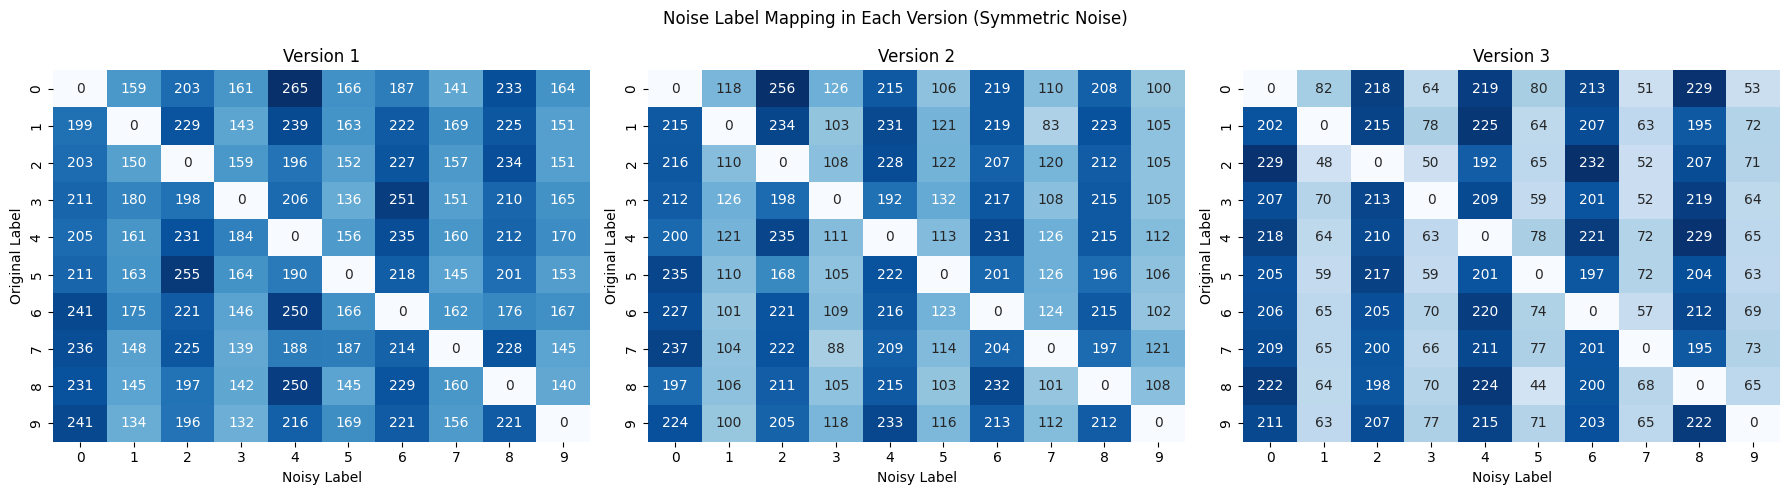

非对称噪声验证：
Error loading labels for version 1: [Errno 2] No such file or directory: '../data/cifar-10/gen/nr_0.2_nt_asymmetric/D_inc_0_labels.npy'
Error loading labels for version 2: [Errno 2] No such file or directory: '../data/cifar-10/gen/nr_0.2_nt_asymmetric/D_inc_0_labels.npy'
Error loading labels for version 3: [Errno 2] No such file or directory: '../data/cifar-10/gen/nr_0.2_nt_asymmetric/D_inc_0_labels.npy'


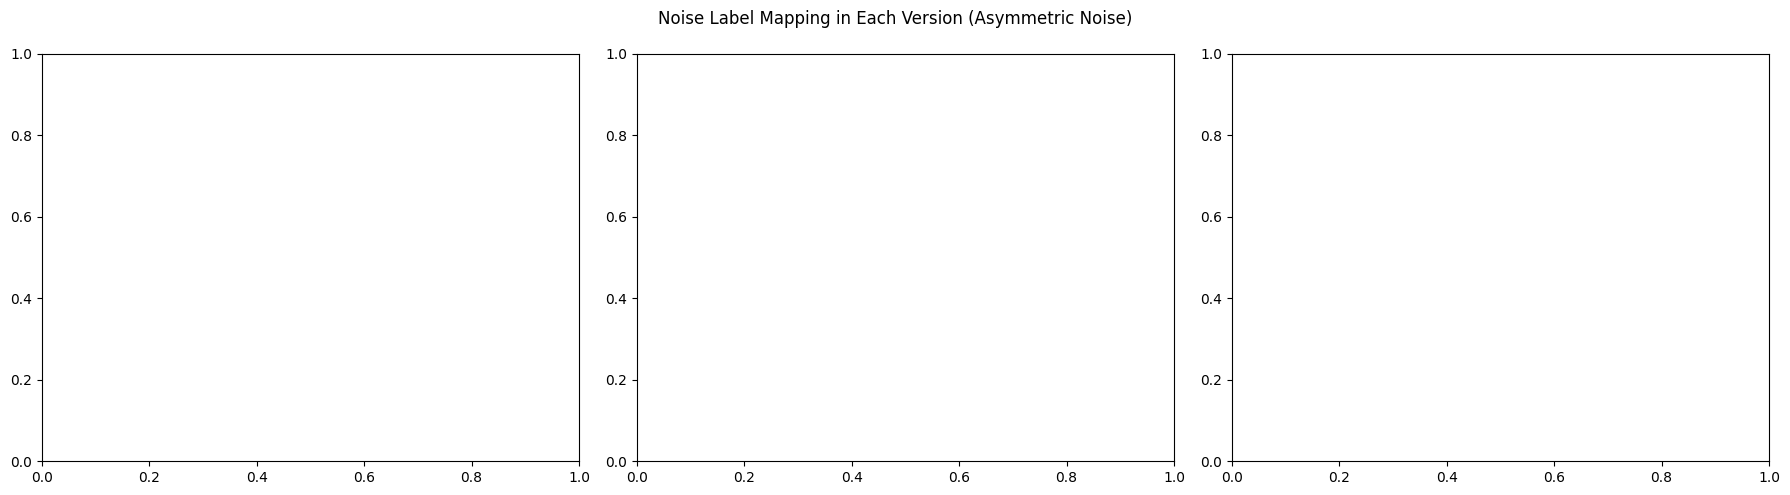

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# 定义数据集的路径
base_dir_1 = "../data/cifar-10/gen/nr_0.2_nt_asymmetric"
base_dir_2 = "../data/cifar-10/gen/nr_0.2_nt_symmetric"
num_versions = 3  # 假设有3个增量版本
num_classes = 10  # CIFAR-10 共有10个类
num_replay_samples = 2500  # D_a 包含的样本数

# 加载每个版本的原始标签和噪声标签
def load_labels(version, base_dir):
    original_labels_path = os.path.join(base_dir, f"D_inc_0_labels.npy")  # 固定增量标签文件名
    noisy_labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")

    try:
        original_labels = torch.load(original_labels_path).numpy()  # 使用 torch.load 并转换为 numpy
        noisy_labels = torch.load(noisy_labels_path).numpy()

        # 调试输出标签的大小
        print(f"Version {version}: original_labels size = {len(original_labels)}, noisy_labels size = {len(noisy_labels)}")

        # 剔除重放数据 D_a 的标签部分
        noisy_labels = noisy_labels[num_replay_samples:]  # 从增量部分开始
        
        # 确保 noisy_labels 和 original_labels 大小一致
        if len(noisy_labels) != len(original_labels):
            print(f"Mismatch detected in version {version}: Adjusting sizes")
            if len(noisy_labels) > len(original_labels):
                noisy_labels = noisy_labels[:len(original_labels)]
            else:
                original_labels = original_labels[:len(noisy_labels)]

        return original_labels, noisy_labels
    except Exception as e:
        print(f"Error loading labels for version {version}: {e}")
        return None, None

# 计算并可视化对称噪声和非对称噪声的效果
def plot_noise_effect(base_dir, noise_type):
    plt.style.use("default")
    fig, axs = plt.subplots(1, num_versions, figsize=(18, 5))
    fig.suptitle(f"Noise Label Mapping in Each Version ({noise_type} Noise)")

    for version in range(1, num_versions + 1):
        original_labels, noisy_labels = load_labels(version, base_dir)

        if original_labels is None or noisy_labels is None:
            continue  # 如果加载失败，则跳过该版本

        # 找到那些被噪声替换的样本
        noise_mask = (original_labels != noisy_labels)  # 标签不同的部分即为噪声
        original_labels_noisy = original_labels[noise_mask]
        noisy_labels_only = noisy_labels[noise_mask]

        # 构建噪声标签的映射矩阵
        noise_mapping_matrix = np.zeros((num_classes, num_classes))  # 记录每个类的噪声标签分布
        for orig, noisy in zip(original_labels_noisy, noisy_labels_only):
            noise_mapping_matrix[orig, noisy] += 1

        # 绘制热力图展示噪声标签的映射
        sns.heatmap(noise_mapping_matrix, ax=axs[version - 1], cmap="Blues", annot=True, fmt=".0f", cbar=False)
        axs[version - 1].set_title(f"Version {version}")
        axs[version - 1].set_xlabel("Noisy Label")
        axs[version - 1].set_ylabel("Original Label")

    plt.tight_layout()
    plt.show()

# 验证对称噪声效果
print("对称噪声验证：")
plot_noise_effect(base_dir_2, "Symmetric")

# 验证非对称噪声效果
print("非对称噪声验证：")
plot_noise_effect(base_dir_1, "Asymmetric")


# CIFAR-100

## Test

/tmp/ipykernel_1996/771292779.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data['D_0'] = torch.load(f"{data_dir}/D_0.npy")
/tmp/ipykernel_1996/771292779.py:21: Futur

Verifying Sampling Balance...
Analyzing dataset: symmetric


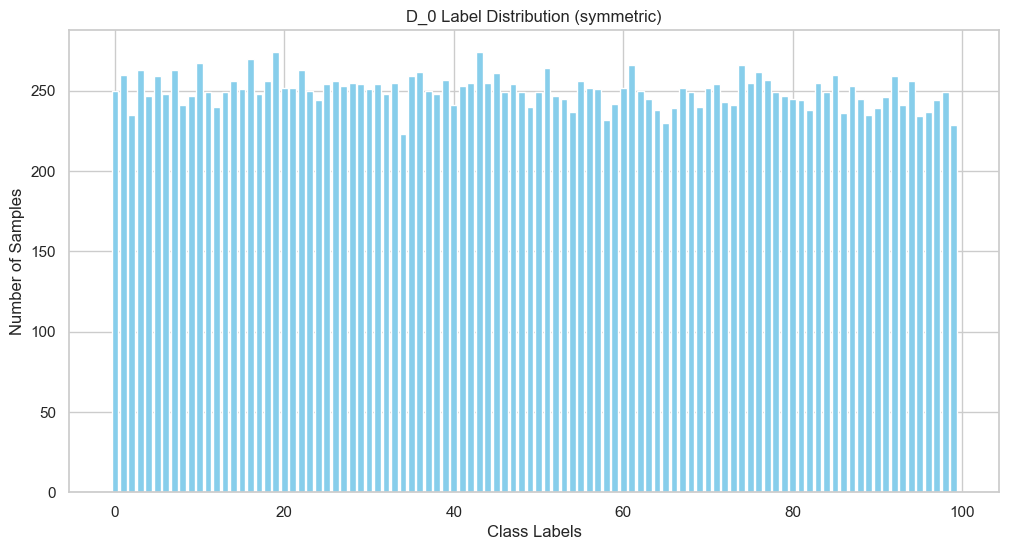

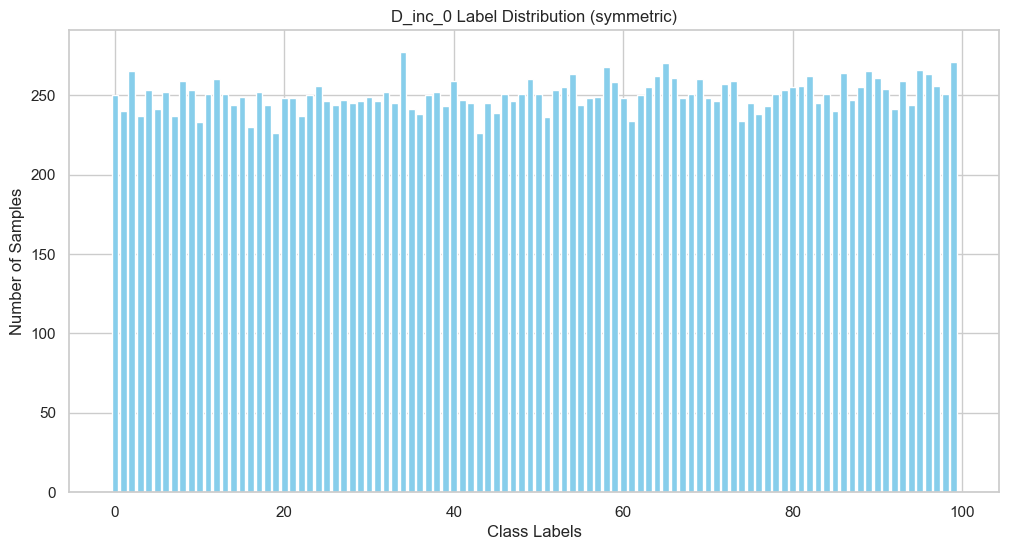

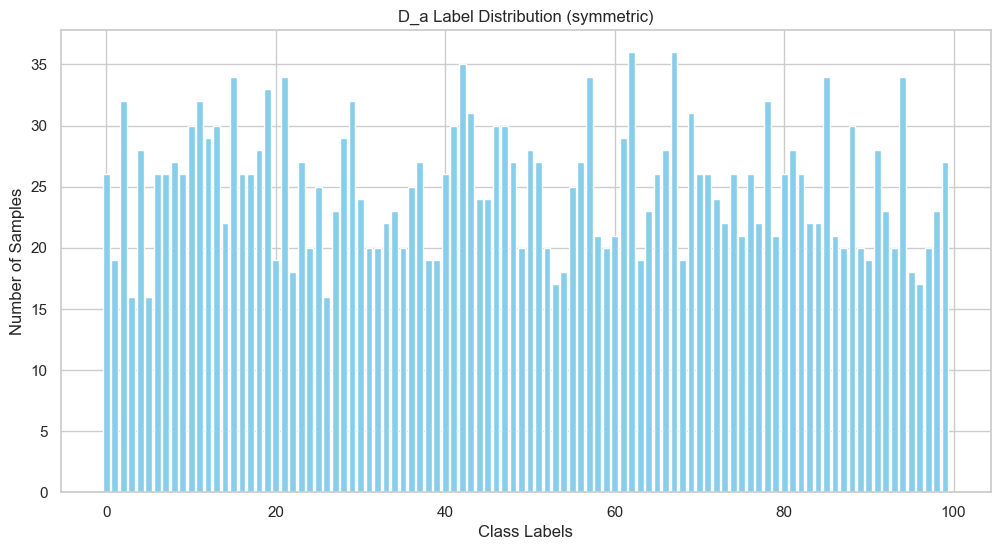

Analyzing dataset: asymmetric


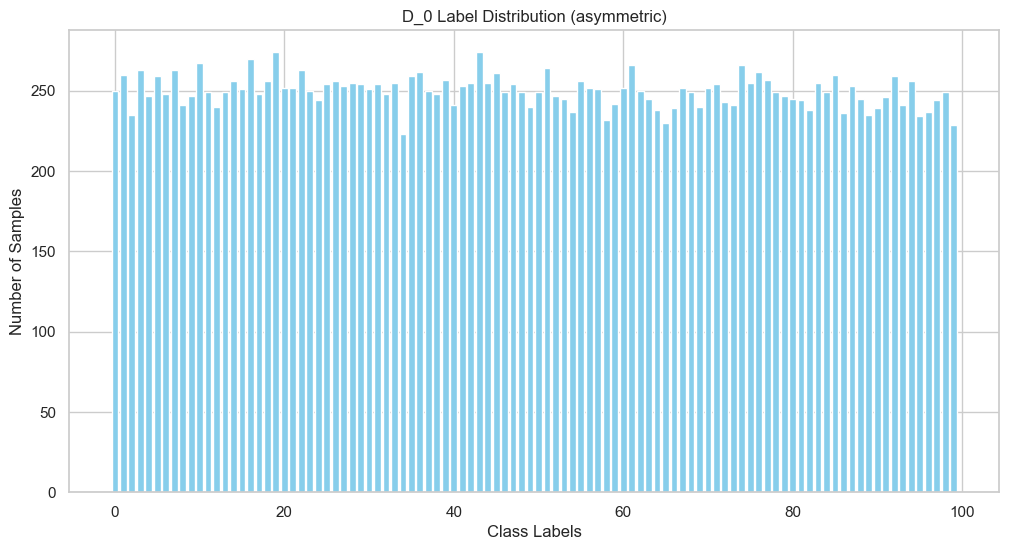

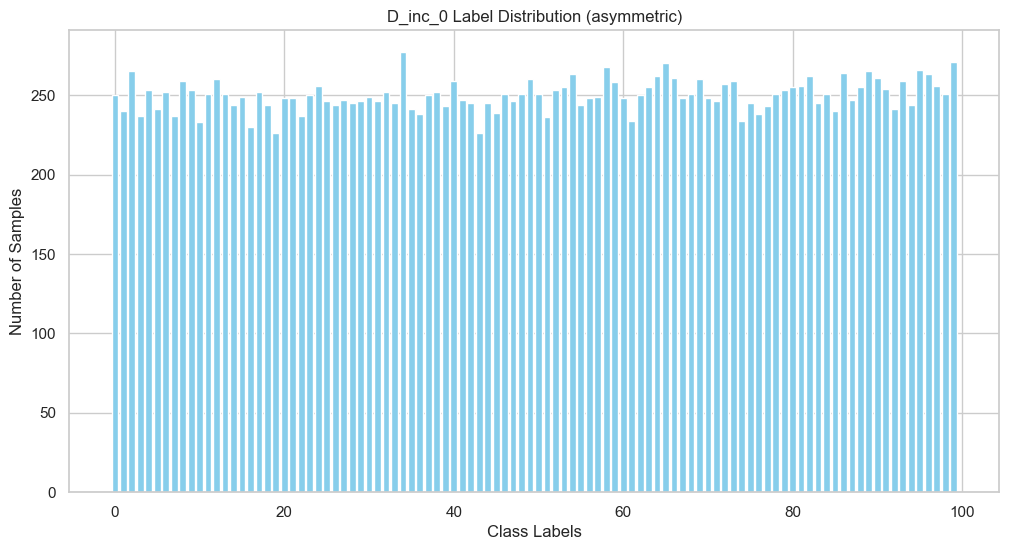

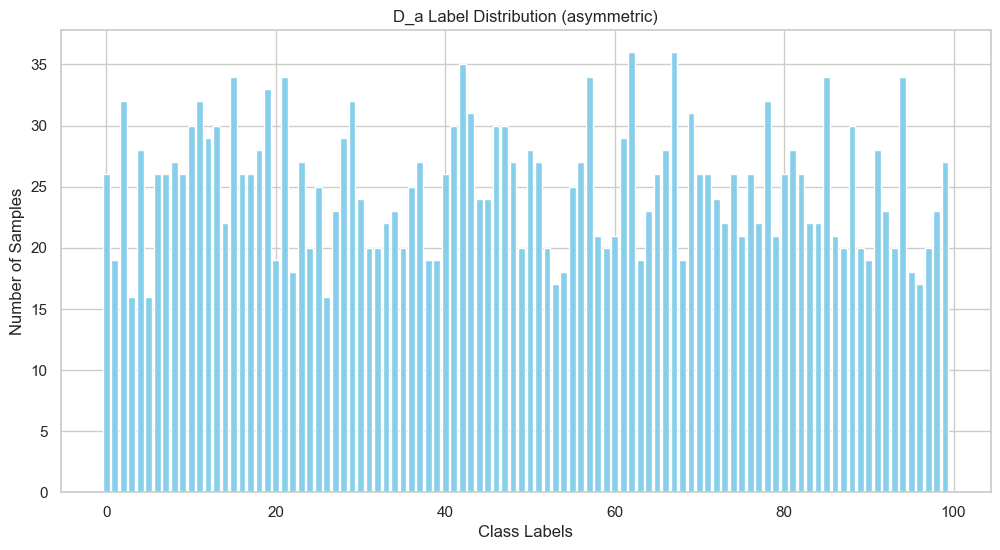

Analyzing dataset: asymmetric_balanced


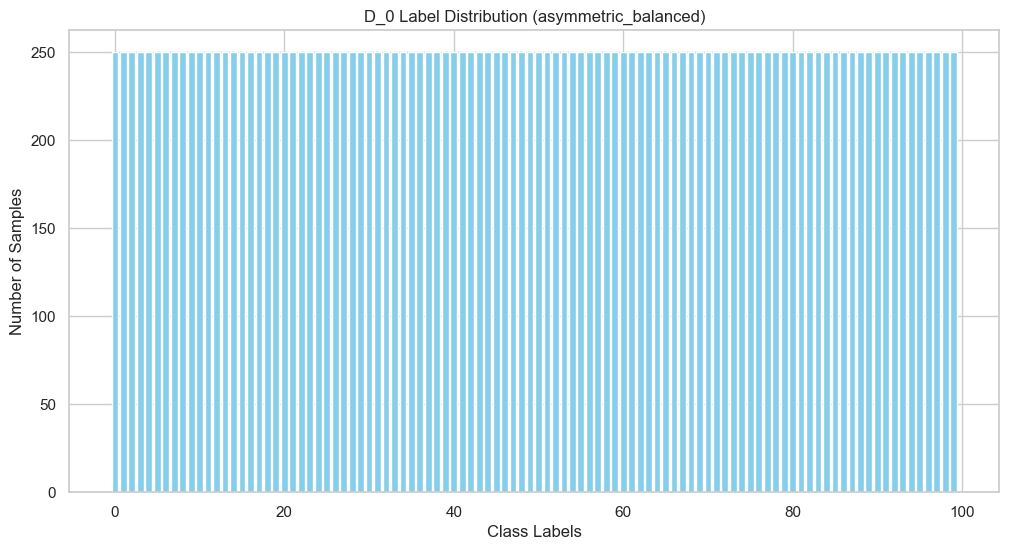

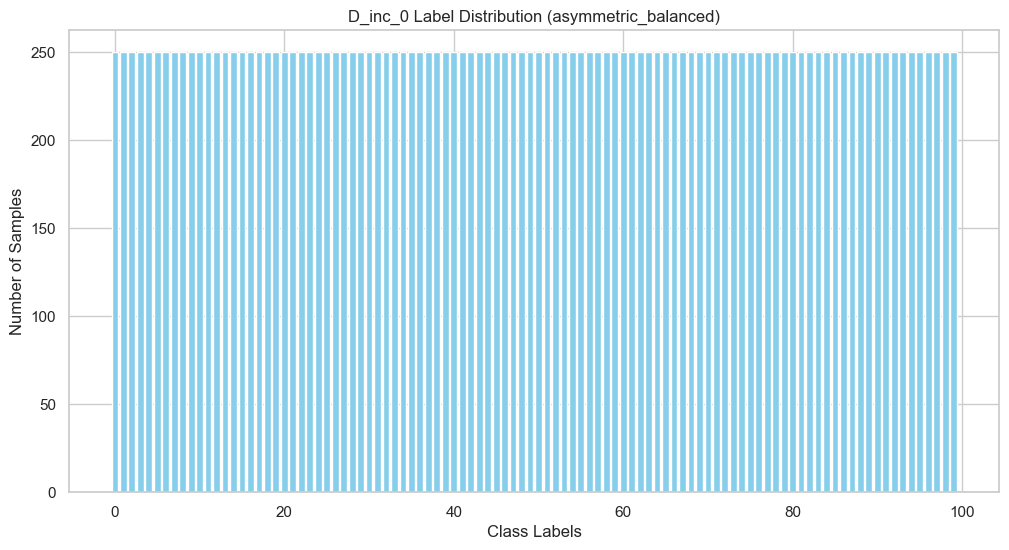

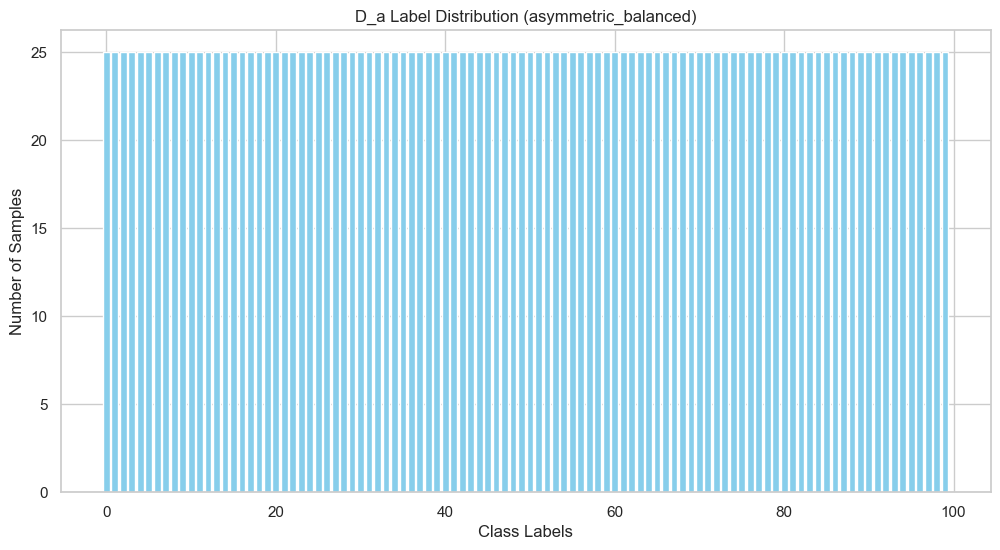

Verifying Forgetting Effect...
Analyzing dataset: symmetric


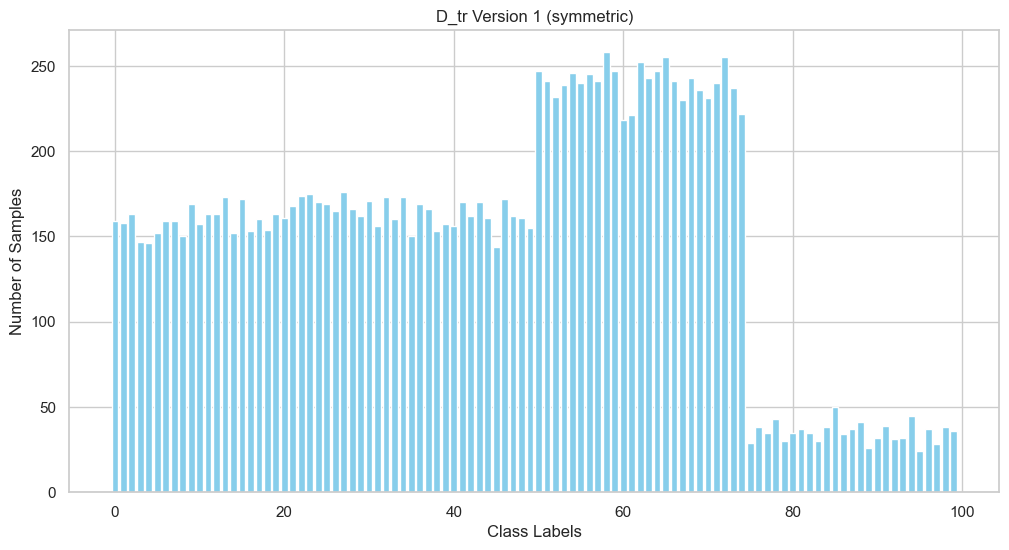

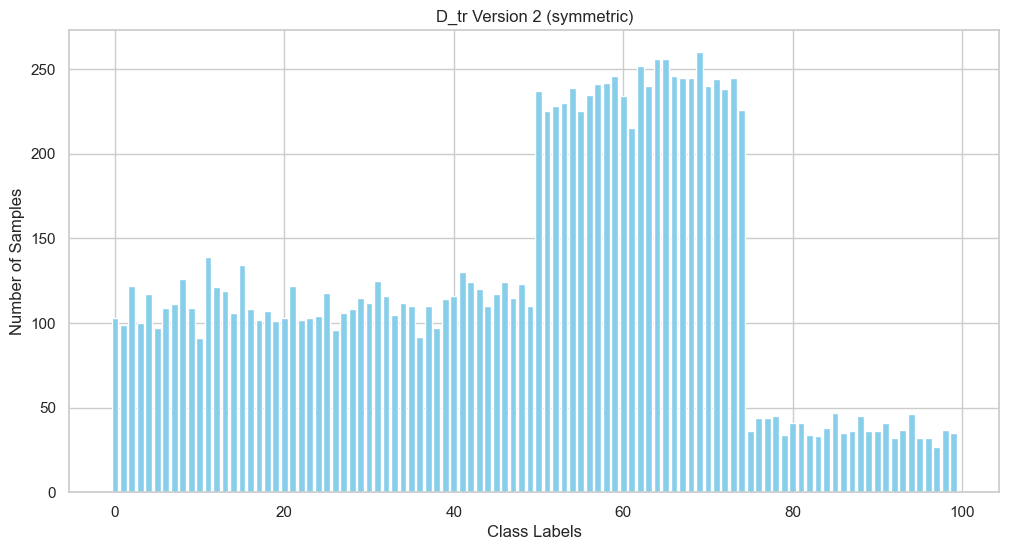

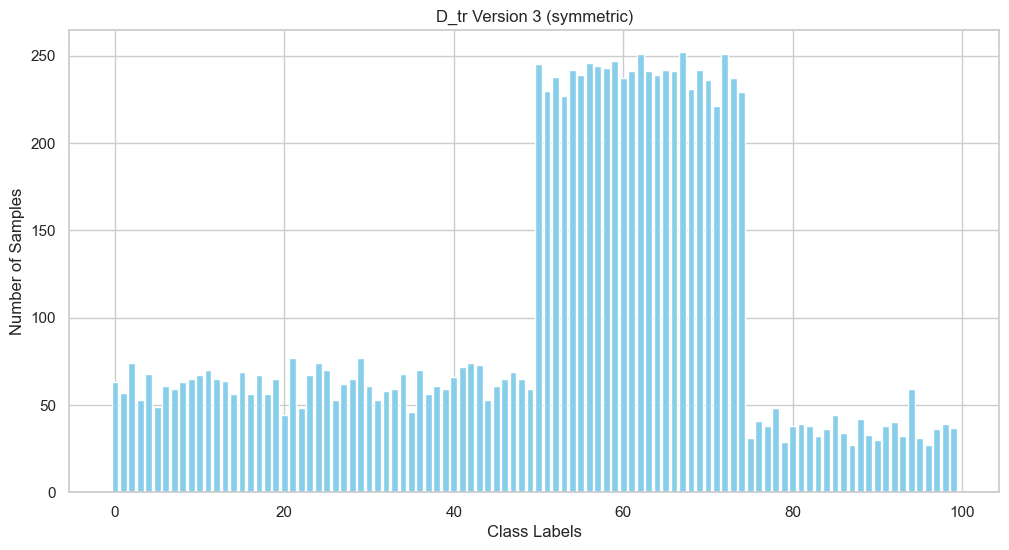

Analyzing dataset: asymmetric


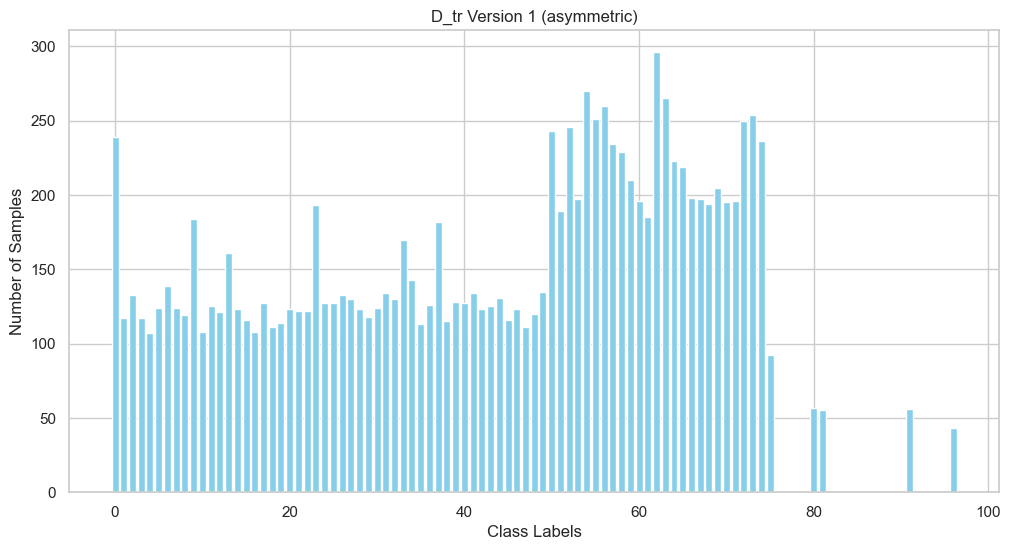

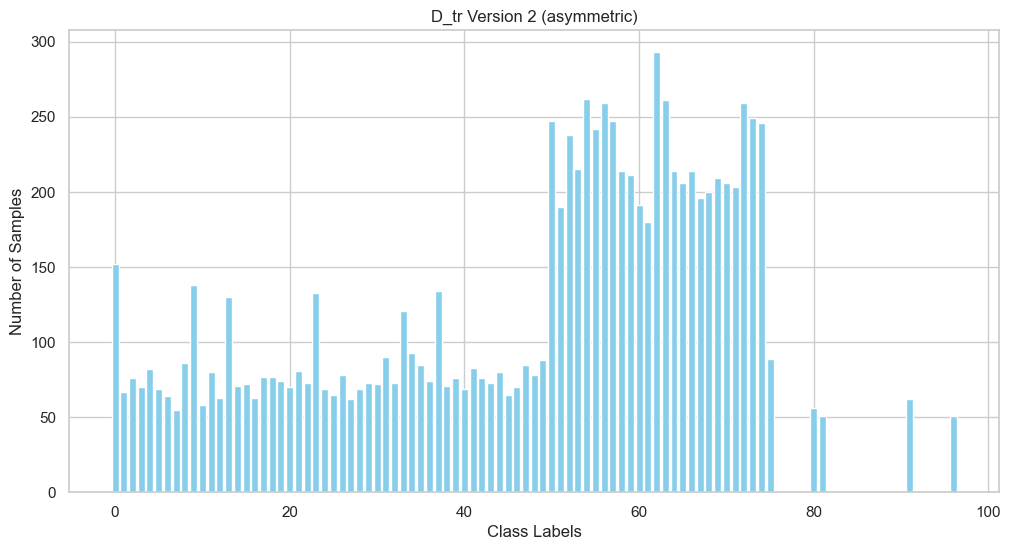

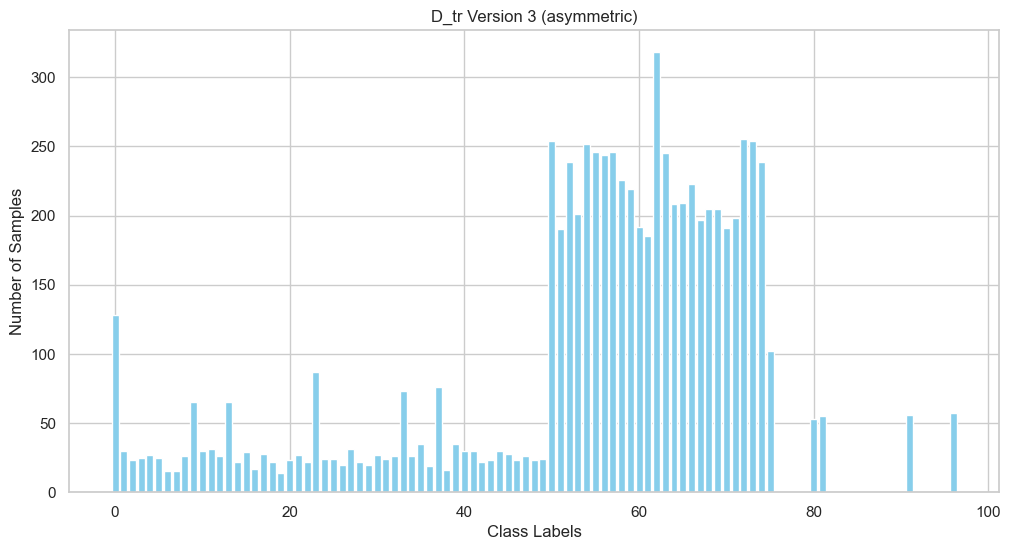

Analyzing dataset: asymmetric_balanced


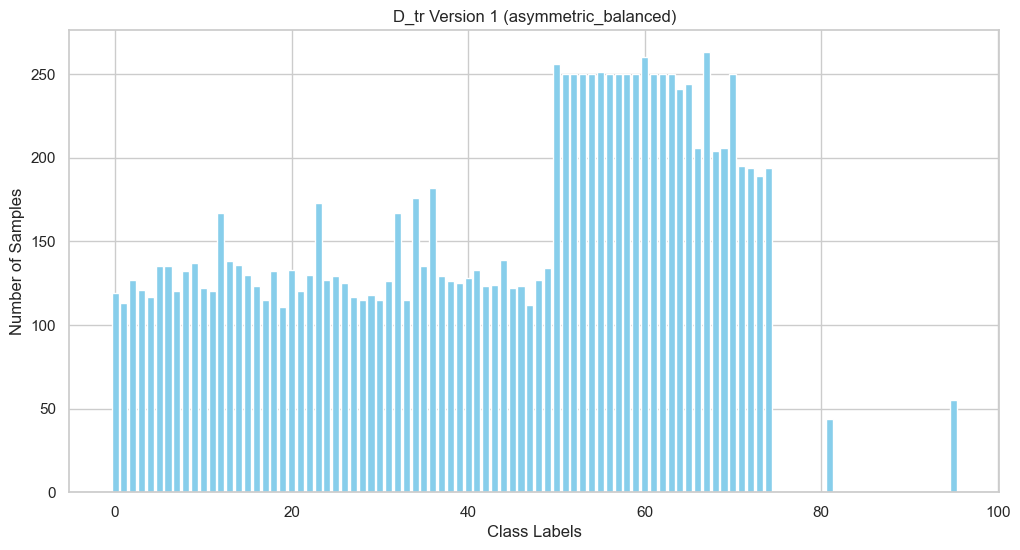

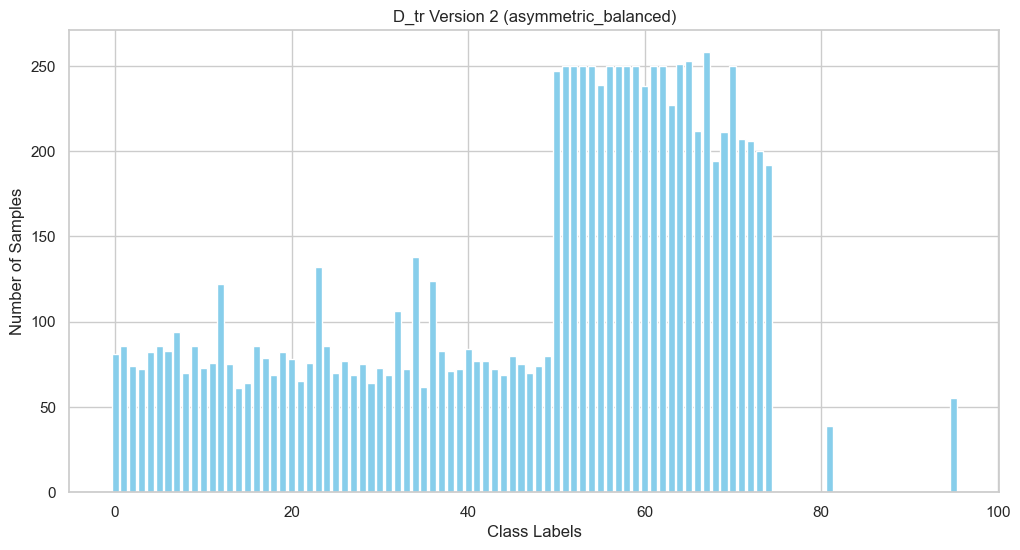

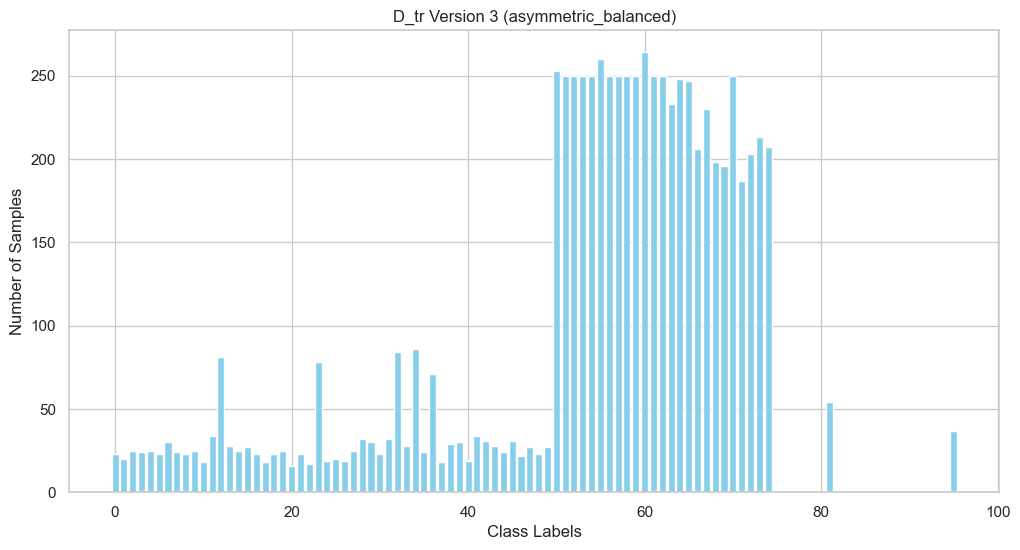

Verifying Noise Effect...
Analyzing dataset: symmetric
Noise effect for symmetric:


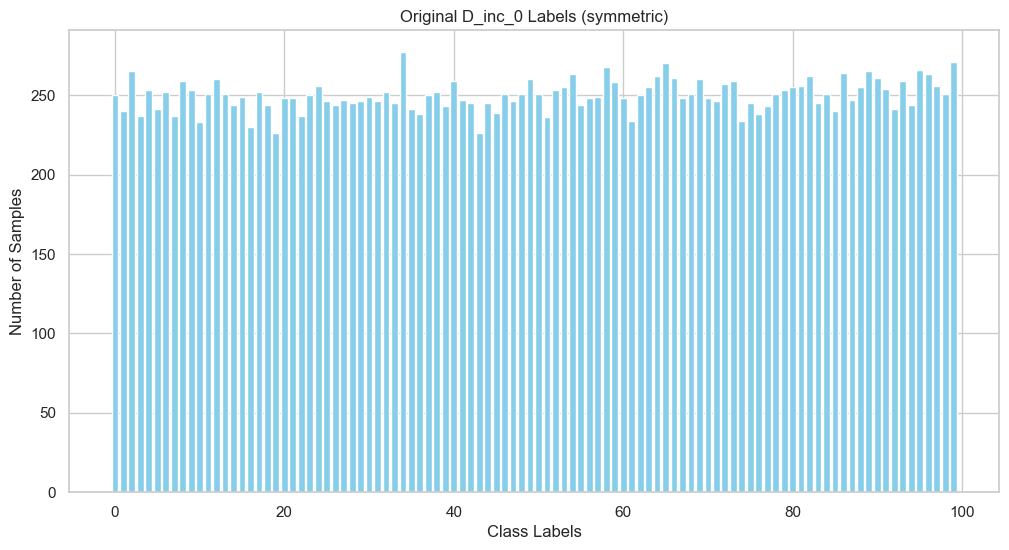

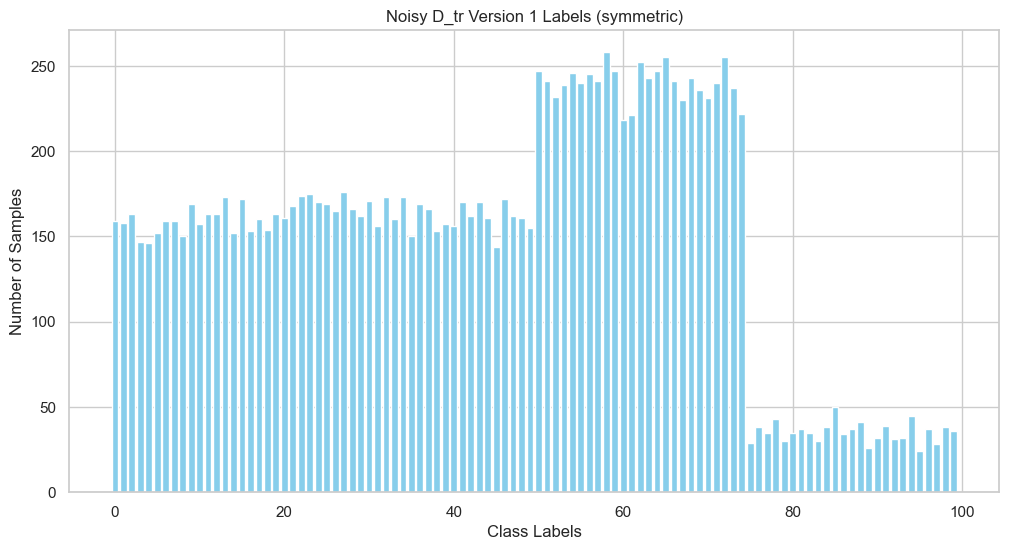

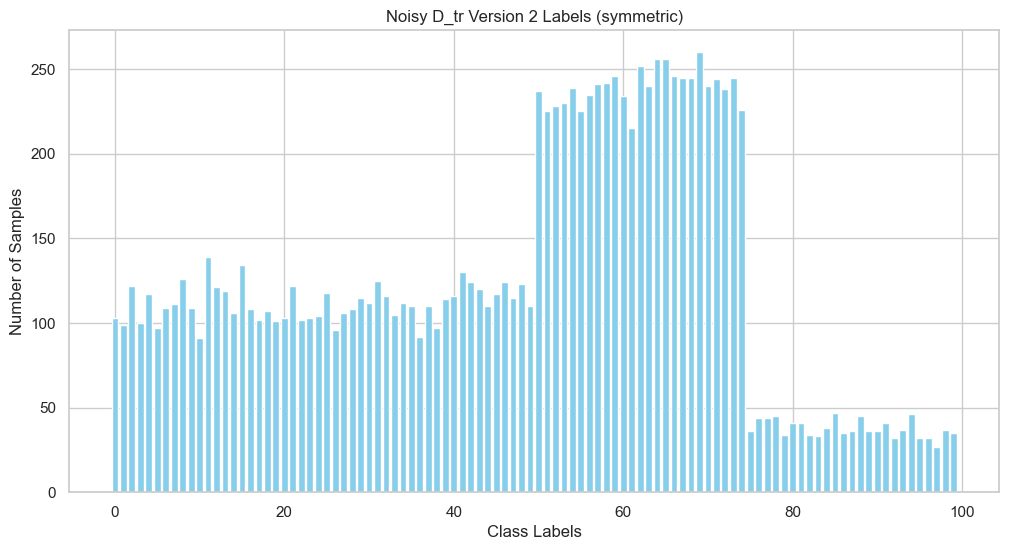

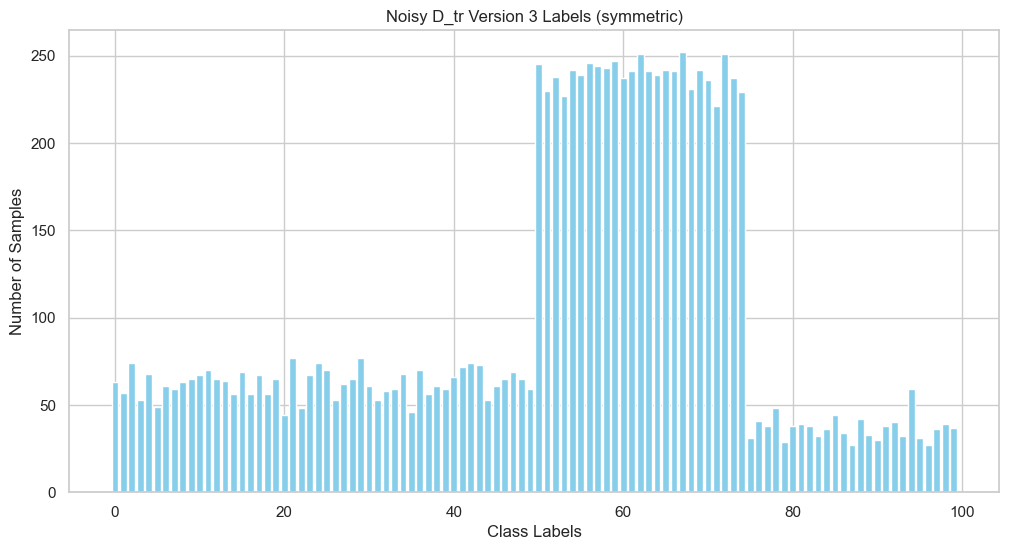

Analyzing dataset: asymmetric
Noise effect for asymmetric:


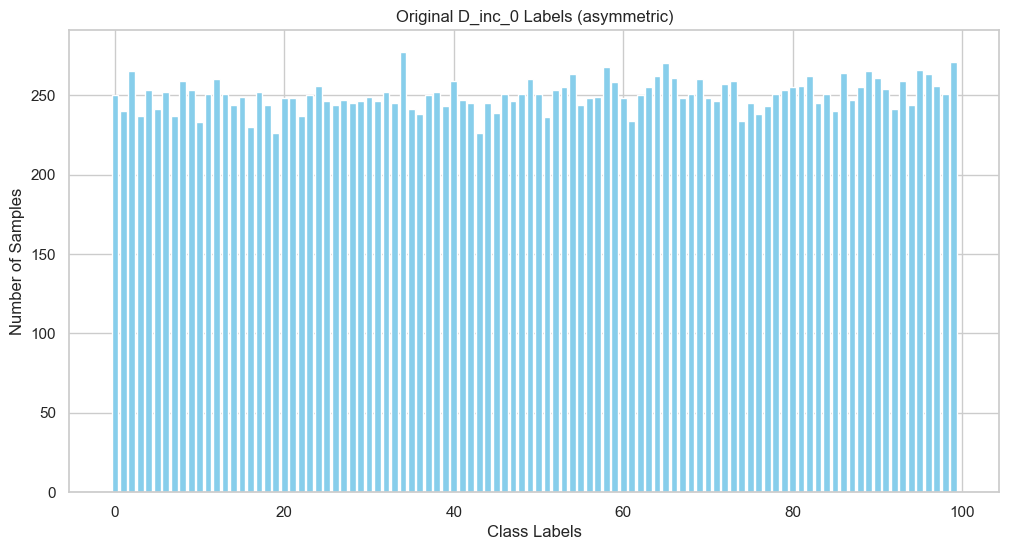

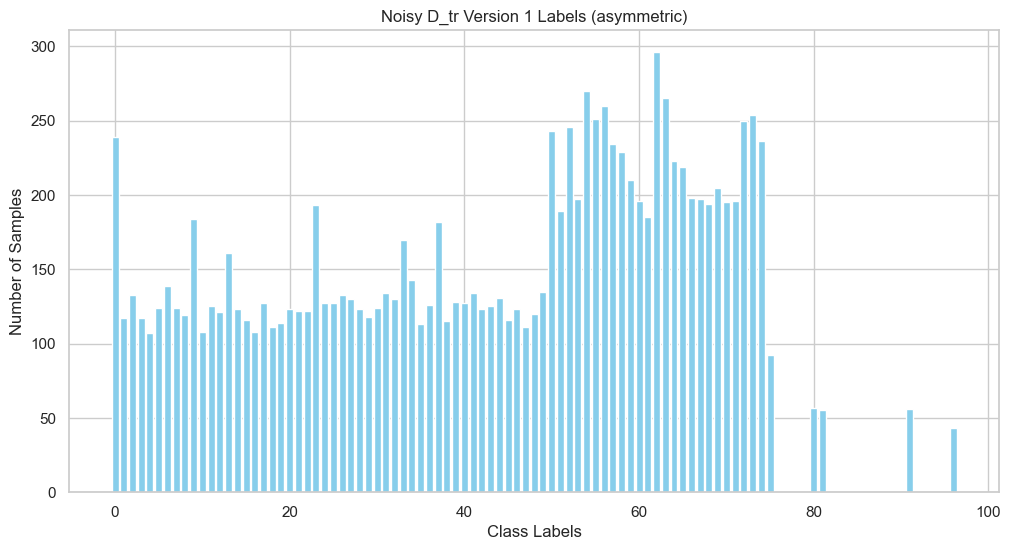

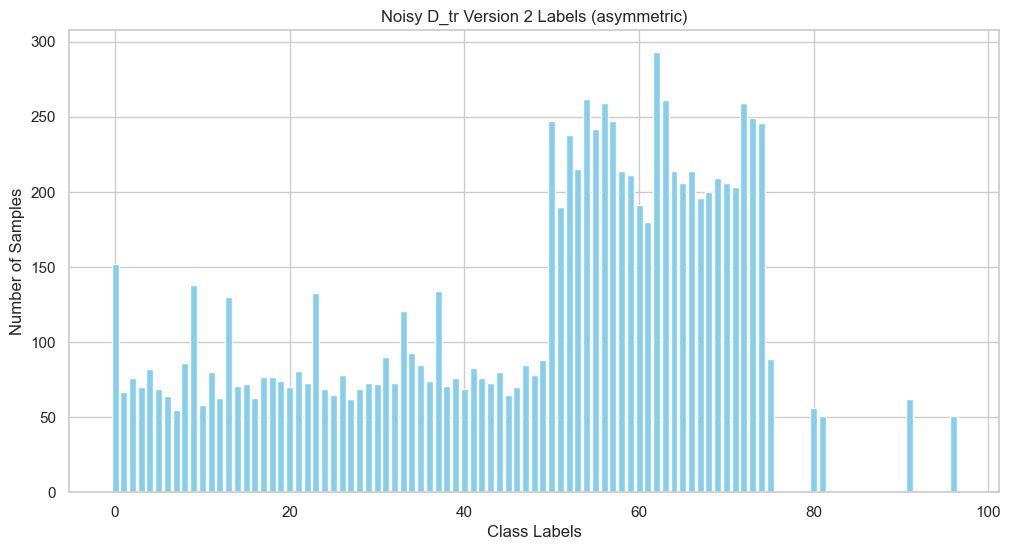

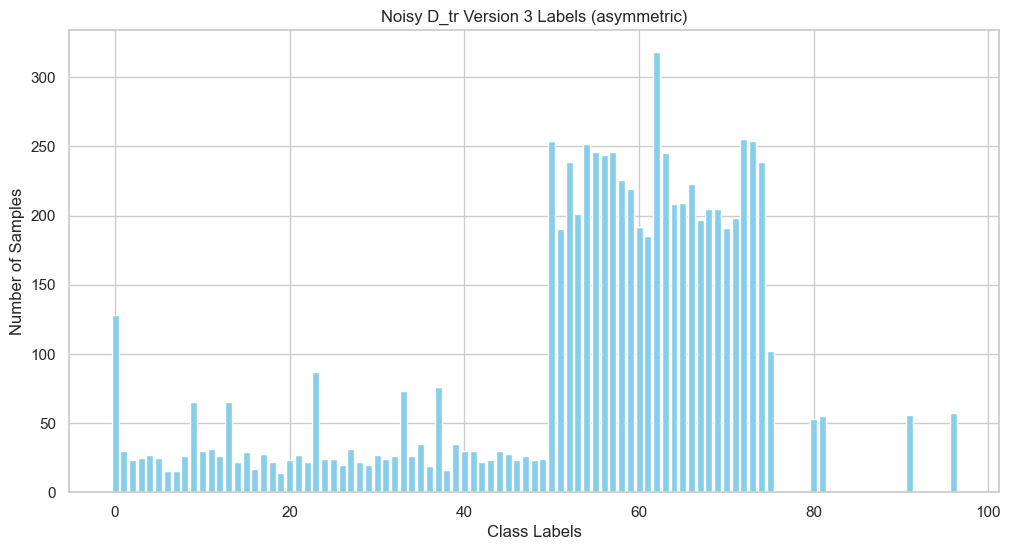

Analyzing dataset: asymmetric_balanced
Noise effect for asymmetric_balanced:


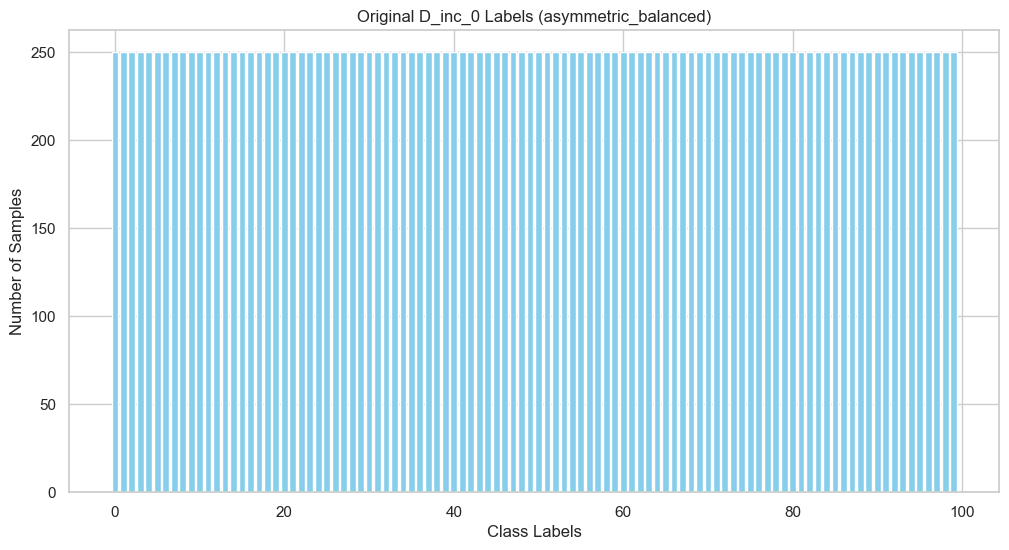

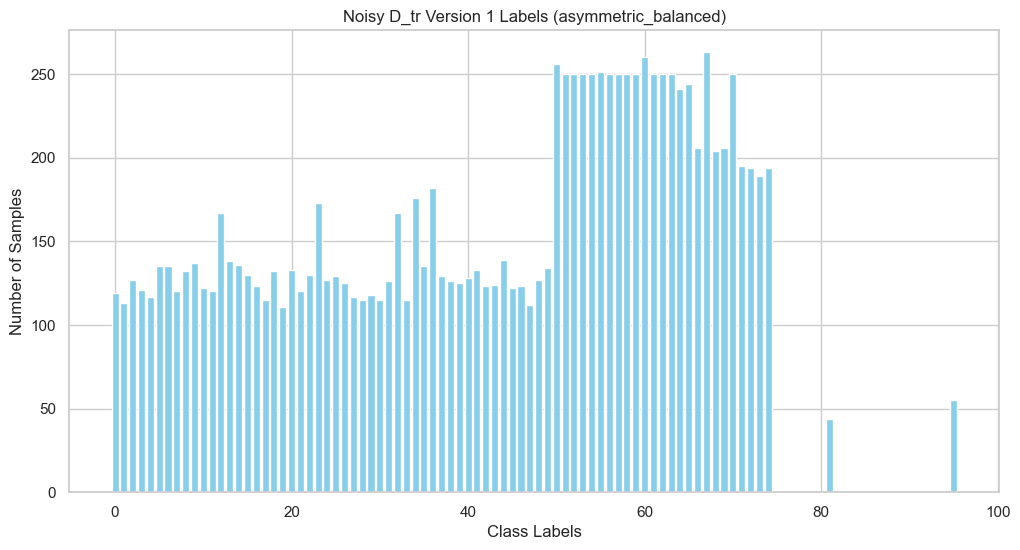

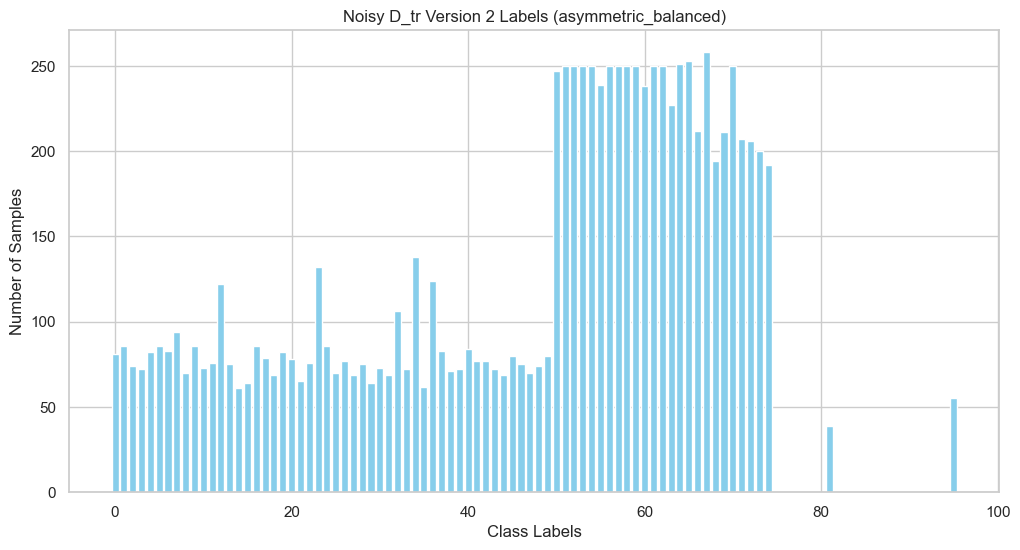

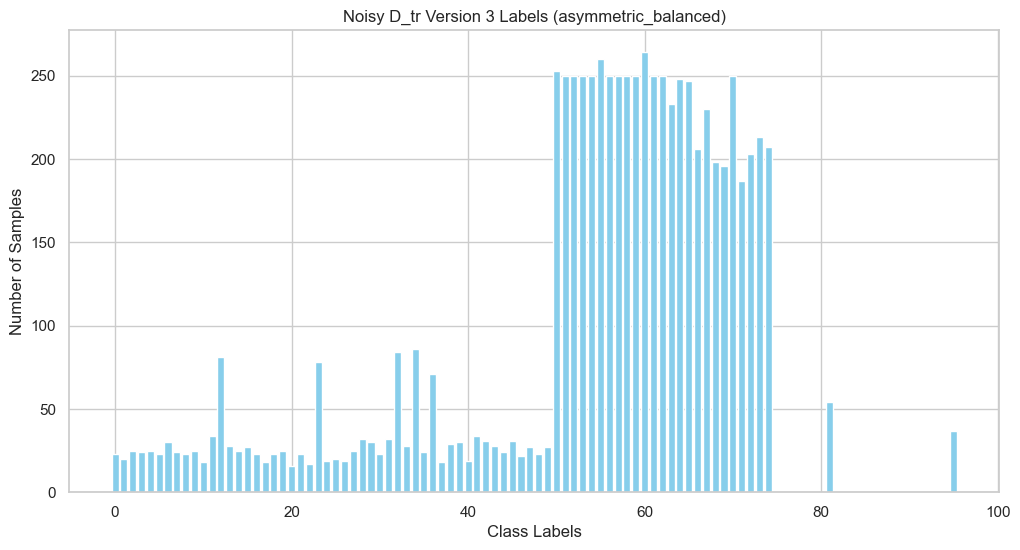

In [23]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 设置 Seaborn 主题
sns.set(style="whitegrid")

# 文件路径
data_dirs = {
    "symmetric": "../data/cifar-100/gen/nr_0.2_nt_symmetric",
    "asymmetric": "../data/cifar-100/gen/nr_0.2_nt_asymmetric",
    "asymmetric_balanced": "../data/cifar-100/gen/nr_0.2_nt_asymmetric_balanced",
}

# 加载数据函数
def load_data(data_dir):
    data = {}
    data['D_0'] = torch.load(f"{data_dir}/D_0.npy")
    data['D_0_labels'] = torch.load(f"{data_dir}/D_0_labels.npy")
    data['D_a'] = torch.load(f"{data_dir}/D_a.npy")
    data['D_a_labels'] = torch.load(f"{data_dir}/D_a_labels.npy")
    data['D_inc_0'] = torch.load(f"{data_dir}/D_inc_0_data.npy")
    data['D_inc_0_labels'] = torch.load(f"{data_dir}/D_inc_0_labels.npy")
    
    # 加载增量训练版本
    data['D_tr_version_1'] = torch.load(f"{data_dir}/D_tr_data_version_1.npy")
    data['D_tr_labels_version_1'] = torch.load(f"{data_dir}/D_tr_labels_version_1.npy")
    data['D_tr_version_2'] = torch.load(f"{data_dir}/D_tr_data_version_2.npy")
    data['D_tr_labels_version_2'] = torch.load(f"{data_dir}/D_tr_labels_version_2.npy")
    data['D_tr_version_3'] = torch.load(f"{data_dir}/D_tr_data_version_3.npy")
    data['D_tr_labels_version_3'] = torch.load(f"{data_dir}/D_tr_labels_version_3.npy")
    
    return data

# 加载所有数据集
datasets = {name: load_data(path) for name, path in data_dirs.items()}

# 数据分析函数
def analyze_label_distribution(labels, title="Label Distribution"):
    label_counts = Counter(labels.tolist())
    labels, counts = zip(*sorted(label_counts.items()))
    plt.figure(figsize=(12, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.show()

# 验证 1：验证采样的随机效果和平衡效果
def verify_sampling_balance():
    print("Verifying Sampling Balance...")
    
    # 对比 D_0 和 D_inc_0 中的类别分布
    for name, dataset in datasets.items():
        print(f"Analyzing dataset: {name}")
        analyze_label_distribution(dataset['D_0_labels'], f"D_0 Label Distribution ({name})")
        analyze_label_distribution(dataset['D_inc_0_labels'], f"D_inc_0 Label Distribution ({name})")
        analyze_label_distribution(dataset['D_a_labels'], f"D_a Label Distribution ({name})")

# 验证 2：验证数据遗忘效果
def verify_forgetting_effect():
    print("Verifying Forgetting Effect...")
    
    # 遍历每个增量版本，检查类别变化
    for name, dataset in datasets.items():
        print(f"Analyzing dataset: {name}")
        analyze_label_distribution(dataset['D_tr_labels_version_1'], f"D_tr Version 1 ({name})")
        analyze_label_distribution(dataset['D_tr_labels_version_2'], f"D_tr Version 2 ({name})")
        analyze_label_distribution(dataset['D_tr_labels_version_3'], f"D_tr Version 3 ({name})")

# 验证 3：验证噪声效果（对称和非对称）
def verify_noise_effect():
    print("Verifying Noise Effect...")
    
    for name, dataset in datasets.items():
        print(f"Analyzing dataset: {name}")
        
        # 对比噪声注入前后的类别分布
        print(f"Noise effect for {name}:")
        analyze_label_distribution(dataset['D_inc_0_labels'], f"Original D_inc_0 Labels ({name})")
        analyze_label_distribution(dataset['D_tr_labels_version_1'], f"Noisy D_tr Version 1 Labels ({name})")
        analyze_label_distribution(dataset['D_tr_labels_version_2'], f"Noisy D_tr Version 2 Labels ({name})")
        analyze_label_distribution(dataset['D_tr_labels_version_3'], f"Noisy D_tr Version 3 Labels ({name})")

# 运行验证函数
verify_sampling_balance()
verify_forgetting_effect()
verify_noise_effect()


## 验证

### 验证遗忘

验证 base_dir_100 数据集:
版本 1:
数据形状: torch.Size([12500, 3, 32, 32]), 标签形状: torch.Size([12500])
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 81 95]
版本 2:
数据形状: torch.Size([10000, 3, 32, 32]), 标签形状: torch.Size([10000])
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 81 95]
版本 3:
数据形状: torch.Size([7500, 3, 32, 32]), 标签形状: torch.Size([7500])
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 81 95]
版本 1:
数据形状: torch.Size([12500, 3, 32, 32])

/tmp/ipykernel_1996/1832703297.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)
/tmp/ipykernel_1996/1832703297.py:15: FutureWarning: You are

版本 2:
数据形状: torch.Size([10000, 3, 32, 32]), 标签形状: torch.Size([10000])
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 81 95]
版本 3:
数据形状: torch.Size([7500, 3, 32, 32]), 标签形状: torch.Size([7500])
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 81 95]


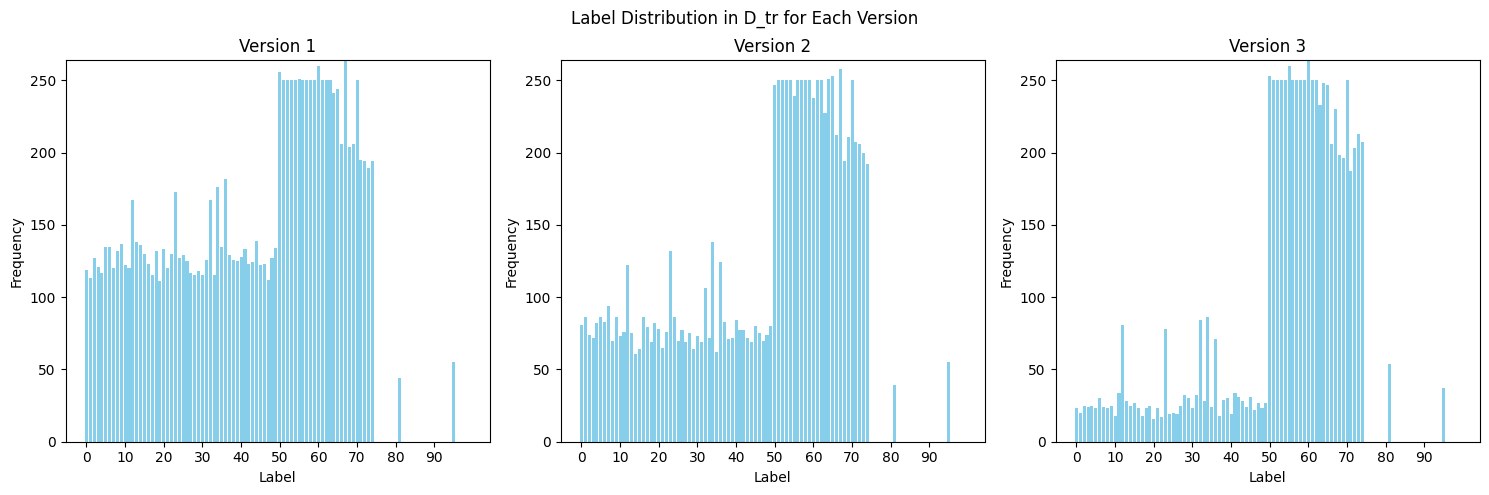

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

num_versions = 3  # 有3个版本的增量数据集
num_classes = 100  # CIFAR-100 共有100个类

# 函数用于加载每个版本的 D_tr 数据集
def load_d_tr(version, base_dir):
    data_path = os.path.join(base_dir, f"D_tr_data_version_{version}.npy")
    labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")
    
    data = torch.load(data_path)
    labels = torch.load(labels_path)
    
    # 验证数据形状和标签范围
    print(f"版本 {version}:")
    print(f"数据形状: {data.shape}, 标签形状: {labels.shape}")
    print(f"标签唯一值: {np.unique(labels)}")
    
    return data, labels

# 验证每个版本 D_tr 的标签分布变化并统一纵坐标
def plot_label_distribution(base_dir):
    plt.style.use("default")
    fig, axs = plt.subplots(1, num_versions, figsize=(15, 5))
    fig.suptitle("Label Distribution in D_tr for Each Version")

    max_count = 0  # 初始化最大频率值

    # 计算所有版本中的最大频率值
    for version in range(1, num_versions + 1):
        _, labels = load_d_tr(version, base_dir)
        _, counts = np.unique(labels, return_counts=True)
        max_count = max(max_count, max(counts))

    # 绘图并设置统一的纵坐标
    for version in range(1, num_versions + 1):
        _, labels = load_d_tr(version, base_dir)
        unique, counts = np.unique(labels, return_counts=True)
        
        # 为了保持 x 轴一致，确保横坐标是从 0 到 99（共100个类）
        full_counts = np.zeros(num_classes)
        full_counts[unique] = counts  # 填充实际的计数值
        
        axs[version - 1].bar(range(num_classes), full_counts, color='skyblue')
        axs[version - 1].set_title(f"Version {version}")
        axs[version - 1].set_xlabel("Label")
        axs[version - 1].set_ylabel("Frequency")
        axs[version - 1].set_xticks(range(0, num_classes, 10))  # 保证横轴一致，间隔10个类
        axs[version - 1].set_ylim(0, max_count)  # 设置统一的纵坐标最大值

    plt.tight_layout()
    fig.subplots_adjust(top=0.88)  # 调整顶部以避免标题与图形重叠
    plt.show()

# 定义数据集的路径
# base_dir_100 = "../data/cifar-100/gen/nr_0.2_nt_symmetric"  # 你可以根据生成数据的实际路径修改
base_dir_100 = "../data/cifar-100/gen/nr_0.2_nt_asymmetric_balanced"  # 你可以根据生成数据的实际路径修改
print("验证 base_dir_100 数据集:")
plot_label_distribution(base_dir_100)


### 验证噪声

/tmp/ipykernel_217127/3589833220.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_labels = torch.load(original_labels_path).numpy()
/tmp/ipykernel_217127/358983

Version 1: original_labels size = 25000, noisy_labels size = 14986
Version 2: original_labels size = 25000, noisy_labels size = 12514
Version 3: original_labels size = 25000, noisy_labels size = 10043


/tmp/ipykernel_217127/3589833220.py:72: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


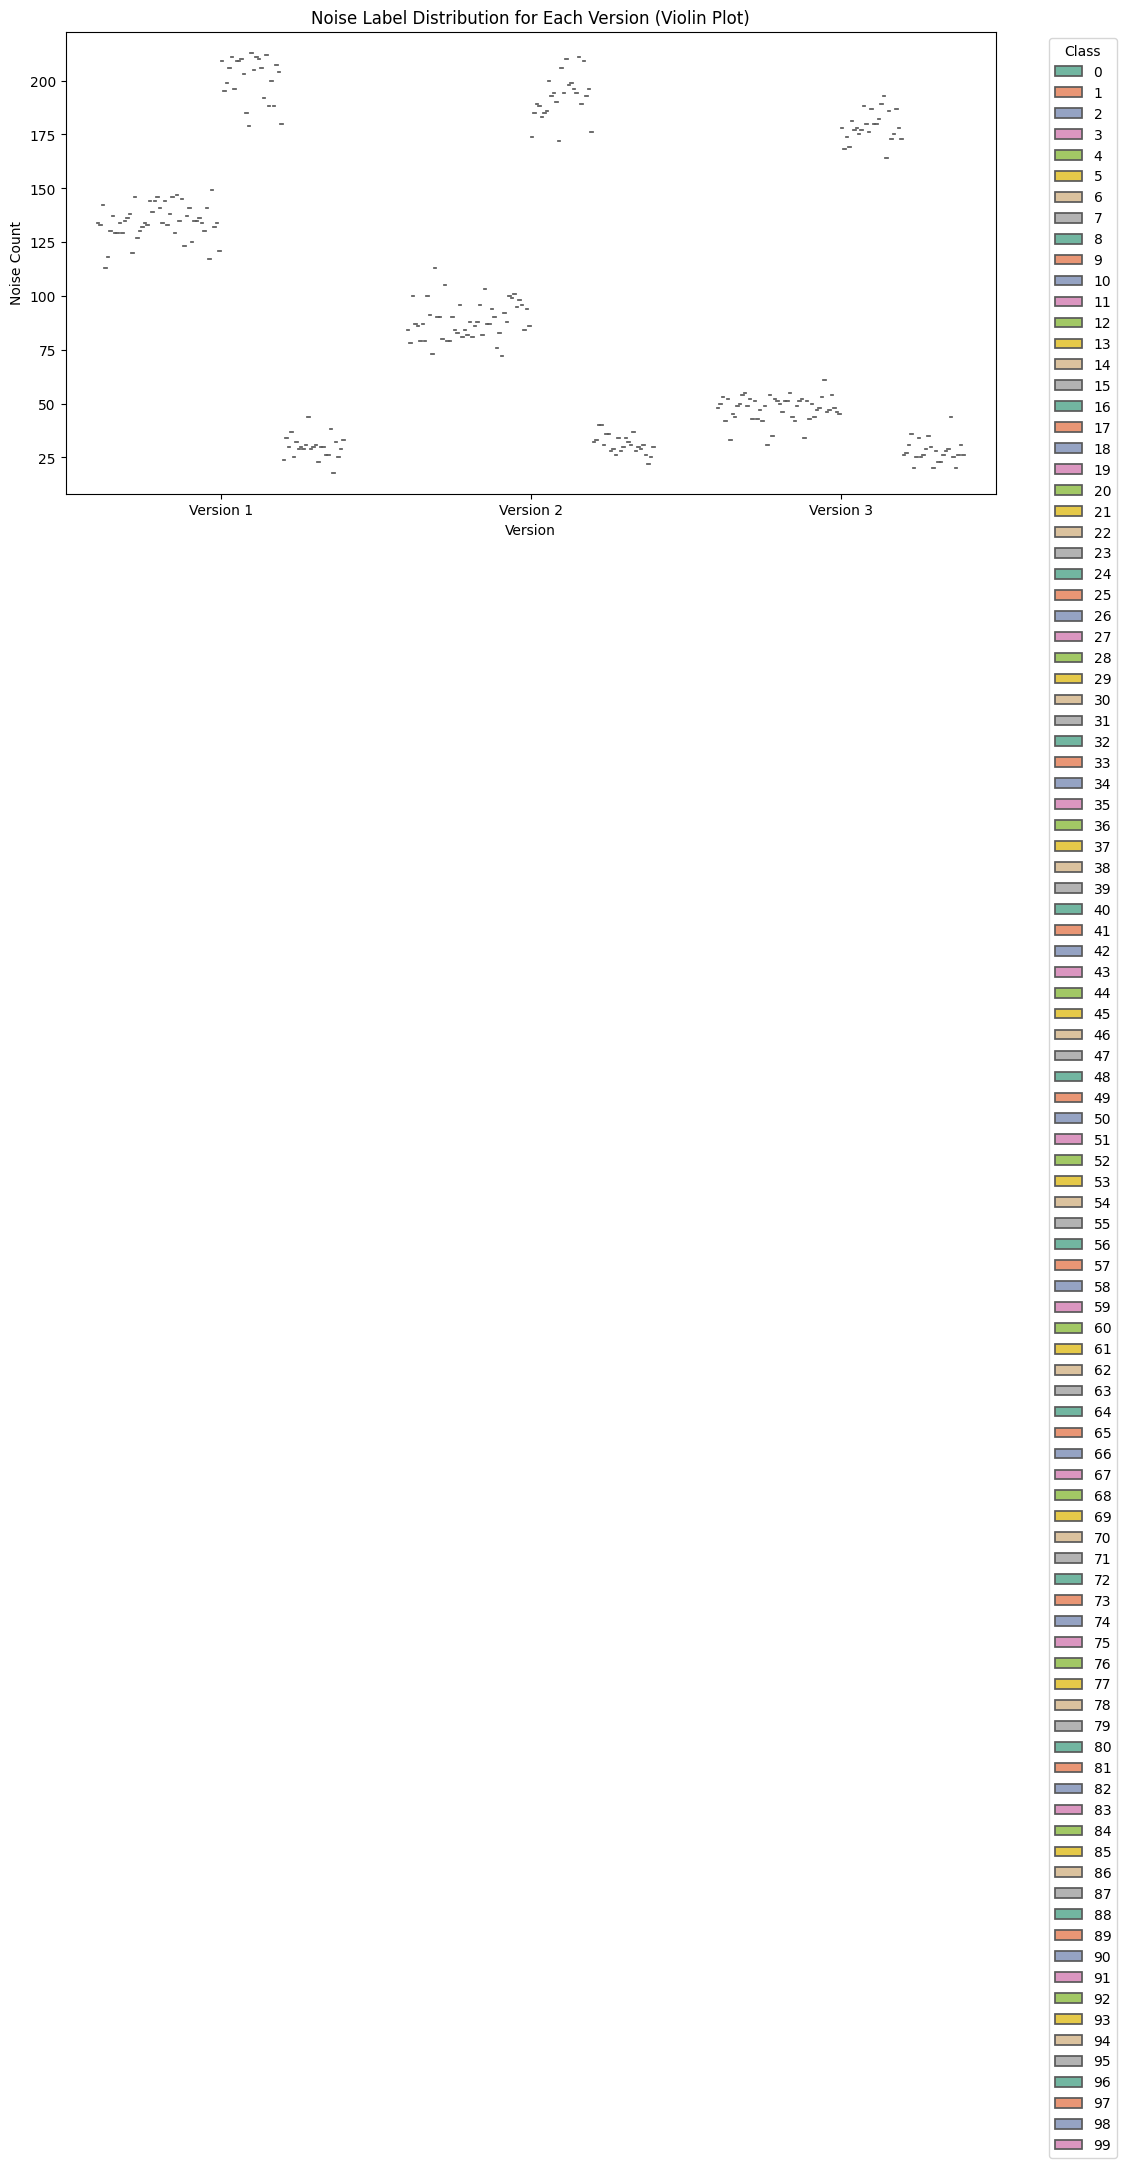

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

num_versions = 3  # 假设有3个增量版本
num_classes = 100  # CIFAR-100 共有100个类
num_replay_samples = 2500  # D_a 包含的样本数

# 加载每个版本的原始标签和噪声标签
def load_labels(version, base_dir):
    original_labels_path = os.path.join(base_dir, "D_inc_0_labels.npy")  # 修正为初始增量标签路径
    noisy_labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")

    try:
        original_labels = torch.load(original_labels_path).numpy()
        noisy_labels = torch.load(noisy_labels_path).numpy()

        # 输出标签的形状以进行调试
        print(f"Version {version}: original_labels size = {original_labels.size}, noisy_labels size = {noisy_labels.size}")

        # 确保 noisy_labels 是一维数组
        if noisy_labels.ndim > 1:
            noisy_labels = noisy_labels.flatten()

        # 确保 noisy_labels 不会超过 original_labels 的长度
        if len(noisy_labels) > len(original_labels):
            noisy_labels = noisy_labels[:len(original_labels)]

        # 剔除重放数据 D_a 的标签部分
        noisy_labels = noisy_labels[num_replay_samples:]  # 从增量部分开始

        return original_labels, noisy_labels
    except Exception as e:
        print(f"Error loading labels for version {version}: {e}")
        return None, None

# 计算并可视化噪声标签比例的变化，使用小提琴图
def plot_noise_violin(base_dir):
    plt.style.use("default")
    plt.figure(figsize=(12, 6))  # 设置整体图像大小

    all_noise_data = []
    all_classes = []
    all_versions = []

    for version in range(1, num_versions + 1):
        original_labels, noisy_labels = load_labels(version, base_dir)
        if original_labels is None or noisy_labels is None:
            continue  # 跳过无法加载的版本

        # 统计噪声标签的数量
        noise_mask = (original_labels != noisy_labels)  # 标签不同的部分即为噪声
        noisy_labels_only = noisy_labels[noise_mask]

        # 对于每个类，计算噪声标签的数量并记录
        for label in range(num_classes):
            noise_per_class = np.sum(noisy_labels_only == label)

            # 记录所有噪声数据、对应的类以及版本
            all_noise_data.append(noise_per_class)  # 直接存储噪声标签数量
            all_classes.append(label)
            all_versions.append(f"Version {version}")

    # 使用Seaborn的小提琴图进行可视化
    sns.violinplot(x=all_versions, y=all_noise_data, hue=all_classes, split=True, inner="quart", palette="Set2")
    plt.title("Noise Label Distribution for Each Version (Violin Plot)")
    plt.xlabel("Version")
    plt.ylabel("Noise Count")
    plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')  # 添加图例
    plt.tight_layout()
    plt.show()

# 定义数据集的路径
base_dir = "../data/cifar-100/gen/nr_0.2_nt_symmetric"  # 根据你的数据生成路径进行调整
# 验证并使用小提琴图可视化各版本中的标签噪声分布
plot_noise_violin(base_dir)


/tmp/ipykernel_217127/3375354811.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_labels = torch.load(original_labels_path).numpy()  # 使用 torch.load
/tmp/ipyker

Version 1: original_labels size = 25000, noisy_labels size = 14986
Version 2: original_labels size = 25000, noisy_labels size = 12514
Version 3: original_labels size = 25000, noisy_labels size = 10043


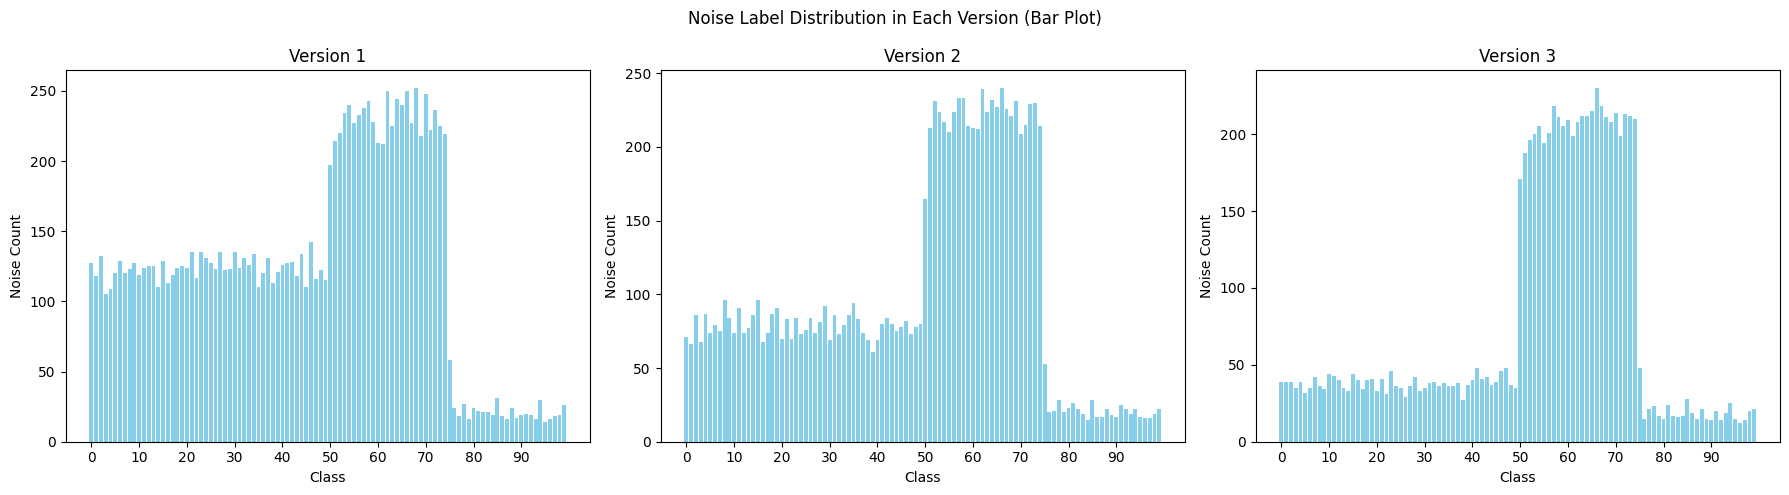

/tmp/ipykernel_217127/3375354811.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_labels = torch.load(original_labels_path).numpy()  # 使用 torch.load
/tmp/ipyker

Version 1: original_labels size = 25000, noisy_labels size = 14986
Version 2: original_labels size = 25000, noisy_labels size = 12514
Version 3: original_labels size = 25000, noisy_labels size = 10043


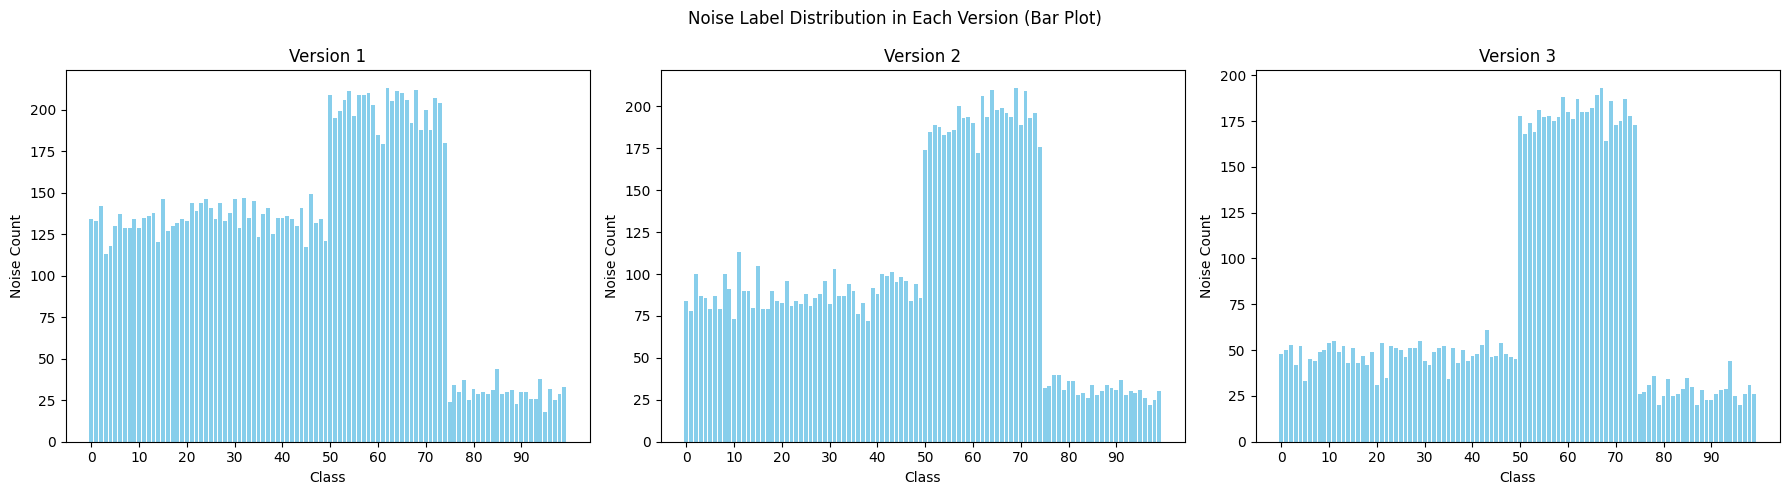

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# 定义数据集的路径
base_dir_asym = "../data/cifar-100/gen/nr_0.2_nt_asymmetric"
base_dir_sym = "../data/cifar-100/gen/nr_0.2_nt_symmetric"
num_versions = 3  # 假设有3个增量版本
num_classes = 100  # CIFAR-100 共有100个类
num_replay_samples = 2500  # D_a 包含的样本数

# 加载每个版本的原始标签和噪声标签
def load_labels(version, base_dir):
    original_labels_path = os.path.join(
        base_dir, f"D_inc_0_labels.npy"
    )  # 使用固定的增量标签文件
    noisy_labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")

    try:
        original_labels = torch.load(original_labels_path).numpy()  # 使用 torch.load
        noisy_labels = torch.load(noisy_labels_path).numpy()

        # 调试输出标签的大小
        print(
            f"Version {version}: original_labels size = {original_labels.size}, noisy_labels size = {noisy_labels.size}"
        )

        # 剔除重放数据 D_a 的标签部分
        noisy_labels = noisy_labels[num_replay_samples:]  # 从增量部分开始

        # 确保 noisy_labels 与 original_labels 大小一致
        if len(noisy_labels) > len(original_labels):
            noisy_labels = noisy_labels[: len(original_labels)]

        return original_labels, noisy_labels
    except Exception as e:
        print(f"Error loading labels for version {version}: {e}")
        return None, None

# 计算并使用条形图显示噪声标签的分布
def plot_noise_bar(base_dir):
    plt.style.use("default")
    fig, axs = plt.subplots(1, num_versions, figsize=(18, 5))
    fig.suptitle("Noise Label Distribution in Each Version (Bar Plot)")

    for version in range(1, num_versions + 1):
        original_labels, noisy_labels = load_labels(version, base_dir)

        if original_labels is None or noisy_labels is None:
            continue  # 如果加载失败，则跳过该版本

        # 统计噪声标签的数量
        noise_mask = original_labels != noisy_labels  # 标签不同的部分即为噪声
        noisy_labels_only = noisy_labels[noise_mask]

        # 统计每个类的噪声标签数量
        noise_counts = np.zeros(num_classes)
        for label in range(num_classes):
            noise_counts[label] = np.sum(noisy_labels_only == label)

        # 绘制条形图
        axs[version - 1].bar(range(num_classes), noise_counts, color="skyblue")
        axs[version - 1].set_title(f"Version {version}")
        axs[version - 1].set_xlabel("Class")
        axs[version - 1].set_ylabel("Noise Count")
        axs[version - 1].set_xticks(range(0, num_classes, 10))  # 每10个类显示一次标签

    plt.tight_layout()
    plt.show()

# 验证并使用条形图可视化各版本中的标签噪声分布
plot_noise_bar(base_dir_asym)
plot_noise_bar(base_dir_sym)


对称噪声验证：
Version 1: original_labels size = 25000, noisy_labels size = 14986
Mismatch detected in version 1: Adjusting sizes
Version 2: original_labels size = 25000, noisy_labels size = 12514
Mismatch detected in version 2: Adjusting sizes


/tmp/ipykernel_217127/3043773983.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_labels = torch.load(original_labels_path).numpy()  # 使用 torch.load 并转换为 numpy


Version 3: original_labels size = 25000, noisy_labels size = 10043
Mismatch detected in version 3: Adjusting sizes


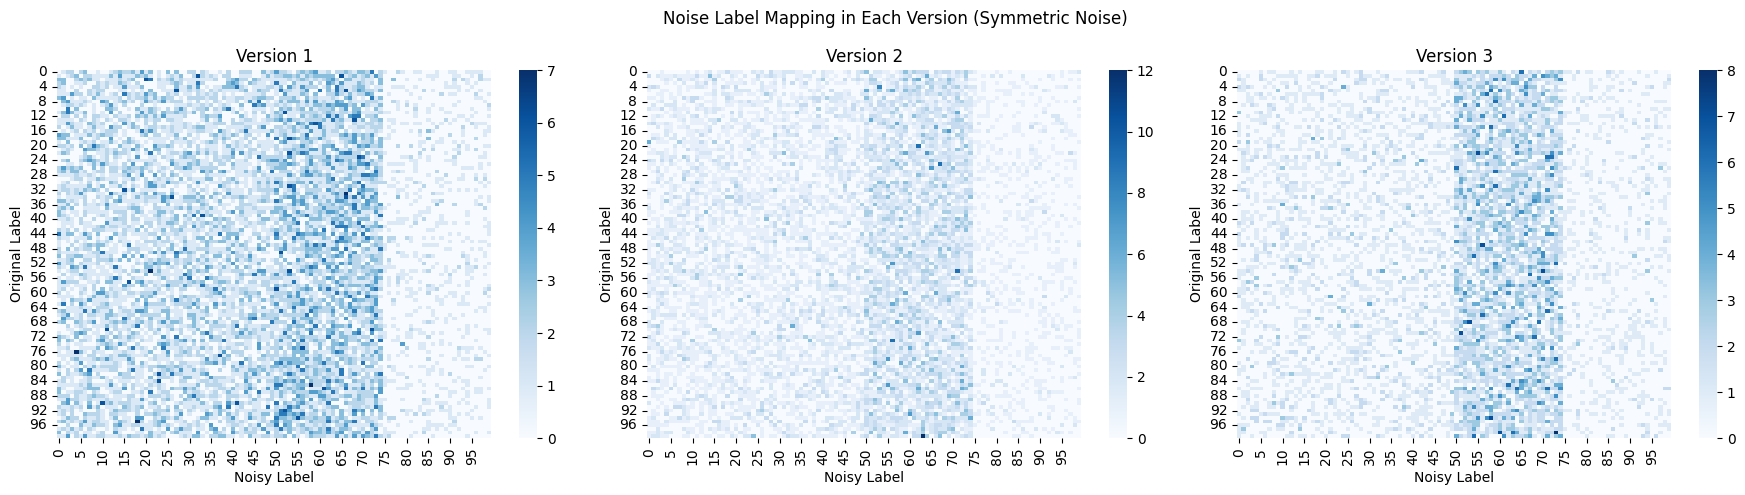

非对称噪声验证：
Version 1: original_labels size = 25000, noisy_labels size = 14986
Mismatch detected in version 1: Adjusting sizes


/tmp/ipykernel_217127/3043773983.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_labels = torch.load(original_labels_path).numpy()  # 使用 torch.load 并转换为 numpy


Version 2: original_labels size = 25000, noisy_labels size = 12514
Mismatch detected in version 2: Adjusting sizes
Version 3: original_labels size = 25000, noisy_labels size = 10043
Mismatch detected in version 3: Adjusting sizes


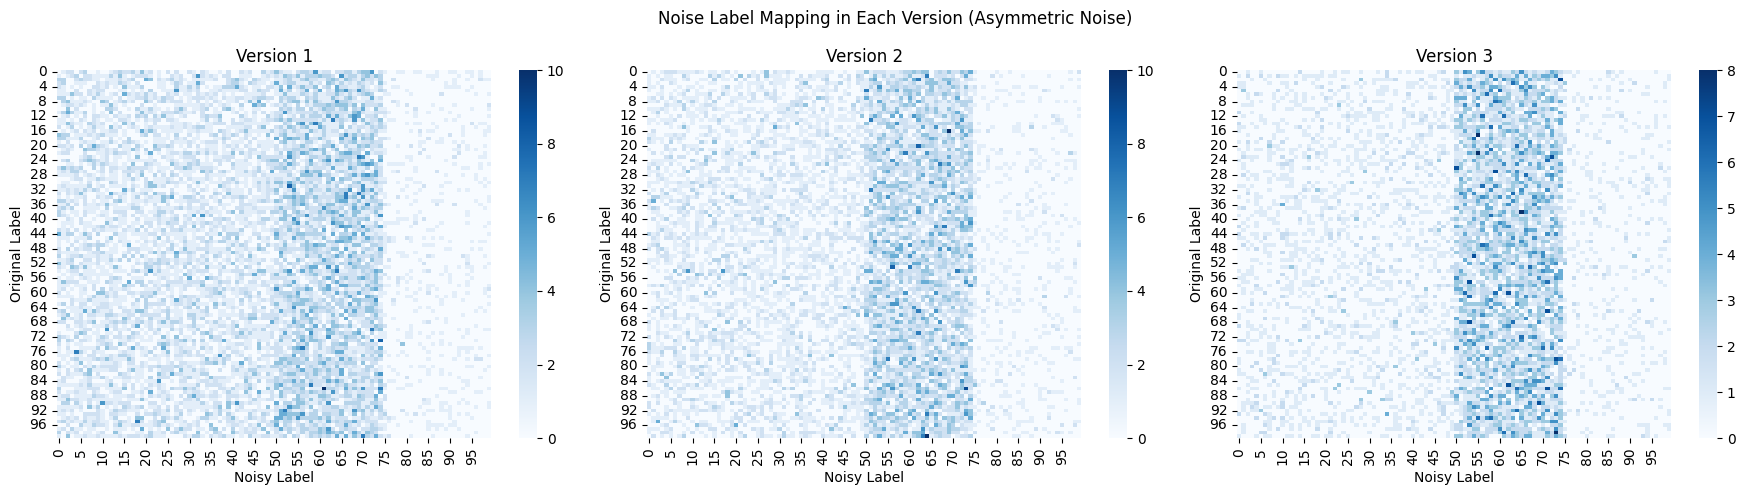

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# 定义数据集的路径
base_dir_asym = "../data/cifar-100/gen/nr_0.2_nt_asymmetric"
base_dir_sym = "../data/cifar-100/gen/nr_0.2_nt_symmetric"
num_versions = 3  # 假设有3个增量版本
num_classes = 100  # CIFAR-100 共有100个类
num_replay_samples = 2500  # D_a 包含的样本数

# 加载每个版本的原始标签和噪声标签
def load_labels(version, base_dir):
    original_labels_path = os.path.join(base_dir, f"D_inc_0_labels.npy")  # 固定增量标签文件名
    noisy_labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")

    try:
        original_labels = torch.load(original_labels_path).numpy()  # 使用 torch.load 并转换为 numpy
        noisy_labels = torch.load(noisy_labels_path).numpy()

        # 调试输出标签的大小
        print(f"Version {version}: original_labels size = {len(original_labels)}, noisy_labels size = {len(noisy_labels)}")

        # 剔除重放数据 D_a 的标签部分
        noisy_labels = noisy_labels[num_replay_samples:]  # 从增量部分开始
        
        # 确保 noisy_labels 和 original_labels 大小一致
        if len(noisy_labels) != len(original_labels):
            print(f"Mismatch detected in version {version}: Adjusting sizes")
            if len(noisy_labels) > len(original_labels):
                noisy_labels = noisy_labels[:len(original_labels)]
            else:
                original_labels = original_labels[:len(noisy_labels)]

        return original_labels, noisy_labels
    except Exception as e:
        print(f"Error loading labels for version {version}: {e}")
        return None, None

# 计算并可视化对称噪声和非对称噪声的效果
def plot_noise_effect(base_dir, noise_type):
    plt.style.use("default")
    fig, axs = plt.subplots(1, num_versions, figsize=(18, 5))
    fig.suptitle(f"Noise Label Mapping in Each Version ({noise_type} Noise)")

    for version in range(1, num_versions + 1):
        original_labels, noisy_labels = load_labels(version, base_dir)

        if original_labels is None or noisy_labels is None:
            continue  # 如果加载失败，则跳过该版本

        # 找到那些被噪声替换的样本
        noise_mask = (original_labels != noisy_labels)  # 标签不同的部分即为噪声
        original_labels_noisy = original_labels[noise_mask]
        noisy_labels_only = noisy_labels[noise_mask]

        # 构建噪声标签的映射矩阵
        noise_mapping_matrix = np.zeros((num_classes, num_classes))  # 记录每个类的噪声标签分布
        for orig, noisy in zip(original_labels_noisy, noisy_labels_only):
            noise_mapping_matrix[orig, noisy] += 1

        # 绘制热力图展示噪声标签的映射
        sns.heatmap(noise_mapping_matrix, ax=axs[version - 1], cmap="Blues", cbar=True)
        axs[version - 1].set_title(f"Version {version}")
        axs[version - 1].set_xlabel("Noisy Label")
        axs[version - 1].set_ylabel("Original Label")

    plt.tight_layout()
    plt.show()

# 验证对称噪声效果
print("对称噪声验证：")
plot_noise_effect(base_dir_sym, "Symmetric")

# 验证非对称噪声效果
print("非对称噪声验证：")
plot_noise_effect(base_dir_asym, "Asymmetric")


# TEST CODES


## get classes

cifar-10

In [6]:
from torchvision import datasets

# 加载 CIFAR-10 数据集
cifar10_dataset = datasets.CIFAR10(root='../../dataset/cifar-10/', train=True, download=True)

# 获取类别名称列表
cifar10_classes = cifar10_dataset.classes

# 打印类别及其对应的标签序号
for i, class_name in enumerate(cifar10_classes):
    print(f"Class {i}: {class_name}")


Files already downloaded and verified
Class 0: airplane
Class 1: automobile
Class 2: bird
Class 3: cat
Class 4: deer
Class 5: dog
Class 6: frog
Class 7: horse
Class 8: ship
Class 9: truck


cifar100

In [10]:
from torchvision import datasets

# 加载 CIFAR-100 数据集
cifar100_dataset = datasets.CIFAR100(root='../../dataset/cifar-100/', train=True, download=True)

# 获取类别名称列表
cifar100_classes = cifar100_dataset.classes

# 打印类别及其对应的标签序号
for i, class_name in enumerate(cifar100_classes):
    print(f"Class {i}: {class_name}")


Files already downloaded and verified
Class 0: apple
Class 1: aquarium_fish
Class 2: baby
Class 3: bear
Class 4: beaver
Class 5: bed
Class 6: bee
Class 7: beetle
Class 8: bicycle
Class 9: bottle
Class 10: bowl
Class 11: boy
Class 12: bridge
Class 13: bus
Class 14: butterfly
Class 15: camel
Class 16: can
Class 17: castle
Class 18: caterpillar
Class 19: cattle
Class 20: chair
Class 21: chimpanzee
Class 22: clock
Class 23: cloud
Class 24: cockroach
Class 25: couch
Class 26: crab
Class 27: crocodile
Class 28: cup
Class 29: dinosaur
Class 30: dolphin
Class 31: elephant
Class 32: flatfish
Class 33: forest
Class 34: fox
Class 35: girl
Class 36: hamster
Class 37: house
Class 38: kangaroo
Class 39: keyboard
Class 40: lamp
Class 41: lawn_mower
Class 42: leopard
Class 43: lion
Class 44: lizard
Class 45: lobster
Class 46: man
Class 47: maple_tree
Class 48: motorcycle
Class 49: mountain
Class 50: mouse
Class 51: mushroom
Class 52: oak_tree
Class 53: orange
Class 54: orchid
Class 55: otter
Class 56:

In [20]:
import json
from collections import defaultdict

def load_classes_from_file(file_path):
    """从文件中读取 CIFAR-100 的类别"""
    with open(file_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]
    return classes

def load_mapping_from_json(file_path):
    """从JSON文件中加载 CIFAR-100 的 superclass 和 child class 的映射"""
    with open(file_path, "r") as f:
        mapping = json.load(f)
    return mapping

def validate_cifar100_mapping(classes_file, mapping_file):
    # 加载类别和映射数据
    cifar_classes = load_classes_from_file(classes_file)
    cifar_mapping = load_mapping_from_json(mapping_file)

    # 用于跟踪每个类别出现在哪些 superclass 中
    class_superclass_map = defaultdict(list)

    # 检查所有类别是否都存在于映射中
    all_mapped_classes = set()
    for superclass, child_classes in cifar_mapping.items():
        for cls in child_classes:
            class_superclass_map[cls].append(superclass)
            all_mapped_classes.add(cls)

    # 未被映射的类
    unmapped_classes = set(cifar_classes) - all_mapped_classes
    if unmapped_classes:
        print("以下类别未在映射中找到：")
        for cls in unmapped_classes:
            print(f" - {cls}")
    else:
        print("所有类别都在映射中找到了对应的 superclass。")

    # 检查是否有重复映射的类别
    duplicated_classes = [cls for cls, superclasses in class_superclass_map.items() if len(superclasses) > 1]
    if duplicated_classes:
        print("\n存在重复映射的类别：")
        for cls in duplicated_classes:
            print(f" - {cls} 出现在超级类: {', '.join(class_superclass_map[cls])}")
    else:
        print("\n没有重复映射的类别。")

    # 打印每个 superclass 及其对应的 child classes
    for superclass, child_classes in cifar_mapping.items():
        print(f"\nSuperclass: {superclass}")
        print(f"Child Classes: {', '.join(child_classes)}")


if __name__ == "__main__":
    # 文件路径
    classes_file = "../configs/classes/cifar_100_classes.txt"
    mapping_file = "../configs/classes/cifar_100_mapping.json"

    # 验证映射
    validate_cifar100_mapping(classes_file, mapping_file)


所有类别都在映射中找到了对应的 superclass。

没有重复映射的类别。

Superclass: aquatic mammals
Child Classes: beaver, dolphin, otter, seal, whale

Superclass: fish
Child Classes: aquarium_fish, flatfish, ray, shark, trout

Superclass: flowers
Child Classes: orchid, poppy, rose, sunflower, tulip

Superclass: food containers
Child Classes: bottle, bowl, can, cup, plate

Superclass: fruit and vegetables
Child Classes: apple, mushroom, orange, pear, sweet_pepper

Superclass: household electrical devices
Child Classes: clock, keyboard, lamp, telephone, television

Superclass: household furniture
Child Classes: bed, chair, couch, table, wardrobe

Superclass: insects
Child Classes: bee, beetle, butterfly, caterpillar, cockroach

Superclass: large carnivores
Child Classes: bear, leopard, lion, tiger, wolf

Superclass: large man-made outdoor things
Child Classes: bridge, castle, house, road, skyscraper

Superclass: large natural outdoor scenes
Child Classes: cloud, forest, mountain, plain, sea

Superclass: large omnivor

food101

In [21]:
import json
from collections import defaultdict

def load_classes_from_file(file_path):
    """从文件中读取 food_101_classes.txt 中的类别"""
    with open(file_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]
    return classes

def load_mapping_from_json(file_path):
    """从JSON文件中加载 food_101 的 superclass 和 child class 的映射"""
    with open(file_path, "r") as f:
        mapping = json.load(f)
    return mapping

def validate_food101_mapping(classes_file, mapping_file):
    # 加载类别和映射数据
    food_classes = load_classes_from_file(classes_file)
    food_mapping = load_mapping_from_json(mapping_file)

    # 用于跟踪每个类别出现在哪些 superclass 中
    class_superclass_map = defaultdict(list)

    # 检查所有类别是否都存在于映射中
    all_mapped_classes = set()
    for superclass, child_classes in food_mapping.items():
        for cls in child_classes:
            class_superclass_map[cls].append(superclass)
            all_mapped_classes.add(cls)

    # 未被映射的类
    unmapped_classes = set(food_classes) - all_mapped_classes
    if unmapped_classes:
        print("以下类别未在映射中找到：")
        for cls in unmapped_classes:
            print(f" - {cls}")
    else:
        print("所有类别都在映射中找到了对应的 superclass。")

    # 检查是否有重复映射的类别
    duplicated_classes = [cls for cls, superclasses in class_superclass_map.items() if len(superclasses) > 1]
    if duplicated_classes:
        print("\n存在重复映射的类别：")
        for cls in duplicated_classes:
            print(f" - {cls} 出现在超级类: {', '.join(class_superclass_map[cls])}")
    else:
        print("\n没有重复映射的类别。")

    # 打印每个 superclass 及其对应的 child classes
    for superclass, child_classes in food_mapping.items():
        print(f"\nSuperclass: {superclass}")
        print(f"Child Classes: {', '.join(child_classes)}")



# 文件路径
classes_file = "../configs/classes/food_101_classes.txt"
mapping_file = "../configs/classes/food_101_mapping.json"

# 验证映射
validate_food101_mapping(classes_file, mapping_file)

所有类别都在映射中找到了对应的 superclass。

没有重复映射的类别。

Superclass: desserts
Child Classes: apple_pie, baklava, beignets, bread_pudding, carrot_cake, cheesecake, chocolate_cake, chocolate_mousse, churros, cup_cakes, donuts, frozen_yogurt, macarons, panna_cotta, red_velvet_cake, strawberry_shortcake, tiramisu, cannoli, creme_brulee, ice_cream

Superclass: salads
Child Classes: beet_salad, caesar_salad, caprese_salad, greek_salad, seaweed_salad

Superclass: sandwiches
Child Classes: breakfast_burrito, club_sandwich, croque_madame, grilled_cheese_sandwich, hamburger, hot_dog, lobster_roll_sandwich, pulled_pork_sandwich

Superclass: meat_dishes
Child Classes: baby_back_ribs, beef_carpaccio, beef_tartare, chicken_curry, chicken_quesadilla, chicken_wings, filet_mignon, foie_gras, fried_chicken, pork_chop, prime_rib, steak

Superclass: seafood
Child Classes: crab_cakes, clam_chowder, fish_and_chips, fried_calamari, grilled_salmon, lobster_bisque, mussels, oysters, scallops, shrimp_and_grits, sushi, sashimi,